# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Análise gráfica de resíduos x previsões
    - 4.4. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.4.1. Ajustes de parâmetros globais para os modelos
        - 4.4.2. Tunagem do modelo **Bayesian Ridge**
        - 4.4.3. Tunagem do modelo **Lasso**
        - 4.4.4. Tunagem do modelo **ElasticNet**
        - 4.4.5. Tunagem do modelo **Ridge**
    - 4.5. Salvando os modelos (.pkl)

<br>

---

<br>

## 1. Importação de bibliotecas

In [98]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import os
import random

from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, 
                                  BayesianRidge, RANSACRegressor,
                                  TheilSenRegressor)
from optuna.samplers import TPESampler

In [99]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [100]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 2999


In [101]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [102]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [103]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [104]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [105]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [106]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [107]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [108]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [109]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [110]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [111]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [112]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [113]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [114]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [115]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [116]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [117]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [118]:
# Definindo os modelos a serem testados

models =  { 
    'LinearRegression (BASELINE)': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
}


In [119]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, métricas para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [120]:
def zscore_norm(series):
    '''
    Normalização Z-score: (x - média) / desvio padrão

    :param series: pd.Series
        Série numérica a ser normalizada.

    :return: pd.Series or float
        Série normalizada usando Z-score.
        Retorna 0.0 caso desvio padrão seja zero (todos iguais).
    '''
    if series.std() == 0:
        return pd.Series(0.0, index=series.index)
    
    return (series - series.mean()) / series.std()


def add_final_score(df, w_mae=0.80, w_time=0.20):
    '''
    Adiciona colunas normalizadas e calcula um ranking Final_Score
    usando Z-score utilizando pesos proporcionais.

    :param df: pd.DataFrame
        DataFrame contendo as métricas dos modelos.
    :param w_mae: float, default=0.80
        Peso atribuído à métrica MAE na composição do score final.
    :param w_time: float, default=0.20
        Peso atribuído ao tempo de execução na composição do score final.   

    :return: pd.DataFrame
        DataFrame com colunas normalizadas e ranking Final_Score.
    '''

    # Normalização robusta
    df['MAE_norm'] = zscore_norm(df['Test_MAE'])
    df['Time_norm'] = zscore_norm(df['Time (s)'])

    # Score final (menor = melhor)
    df['Final_Score'] = (
        w_mae * df['MAE_norm'] +
        w_time * df['Time_norm']
    )

    # Ordenação para ranking
    df.sort_values('Final_Score', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [121]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_ranked = pd.DataFrame(results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_default = add_final_score(df_ranked)

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]

,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,BayesianRidge,638.908211,588.939077,0.2779,-0.545506,-0.456218,-0.527648
1,Lasso,771.712695,783.743438,0.3371,-0.372820,-0.400687,-0.378393
2,Ridge,855.427365,879.050373,0.2839,-0.288334,-0.450590,-0.320785
3,LinearRegression (BASELINE),645.447939,561.578690,2.6705,-0.569760,1.788100,-0.098188
4,ElasticNet,3129.161097,3208.260115,0.2519,1.776419,-0.480606,1.325014


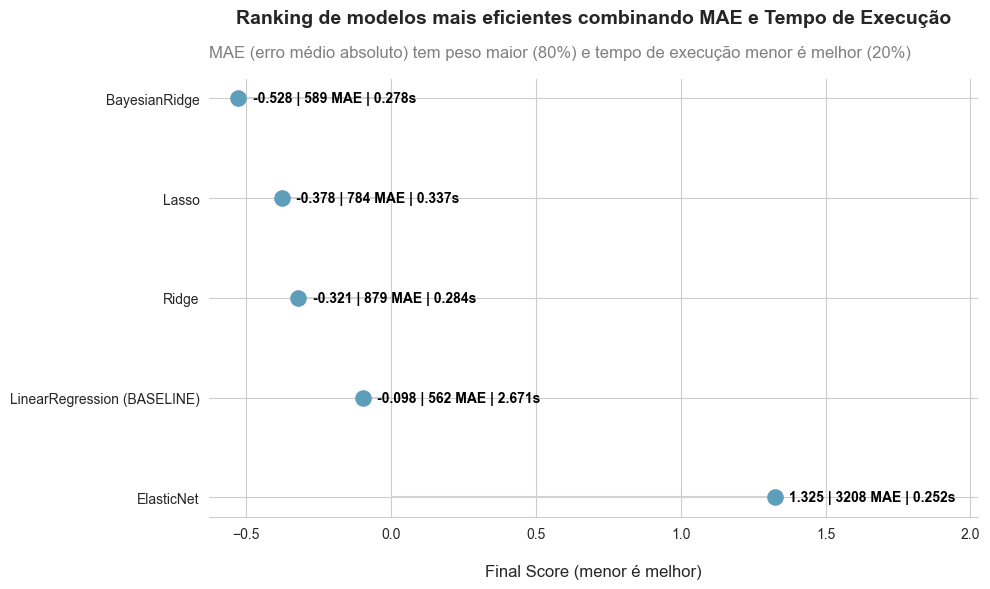

In [ ]:
# Ordenar os modelos pelo Final_Score para o gráfico
df_plot = df_ranked_default.sort_values(by='Final_Score', ascending=False)

# Figura e eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Linha horizontal
ax.hlines(y=df_plot['Model'], xmin=df_plot['Final_Score'], xmax=0,
    color='lightgray', linewidth=1.5)

# Pontos no valor real
ax.scatter(df_plot['Final_Score'], df_plot['Model'], 
           color='#5d9eba', s=120, zorder=3)

# Adicionar texto com MAE e tempo
for score, mae, time_s, model in zip(
    df_plot['Final_Score'], df_plot['Test_MAE'], df_plot['Time (s)'], df_plot['Model']):
    ax.text(score + 0.05, model, f'{score:.3f} | {mae:.0f} MAE | {time_s:.3f}s',
        fontweight='bold', va='center', fontsize=10, color='#000000')

# Título e labels
ax.set_title('Ranking de modelos mais eficientes combinando MAE e Tempo de Execução',
             fontsize=14, fontweight='bold', pad=40)
ax.set_xlabel('\nFinal Score (menor é melhor)', fontsize=12)
ax.set_ylabel('')

# Subtítulo explicativo
ax.text(0, 1.05, 
        'MAE (erro médio absoluto) tem peso maior (80%) e tempo de execução menor é melhor (20%)',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)

# Ajuste de eixo para não cortar textos
ax.set_xlim(df_plot['Final_Score'].min() - 0.1,
            df_plot['Final_Score'].max() + 0.7)

# limpar borda superior e direita
sns.despine(left=True, bottom=False) 

# Ajuste final do layout para evitar sobreposição
plt.tight_layout()

# Exibição do gráfico
plt.show()


### 4.3. Análise gráfica de resíduos x previsões

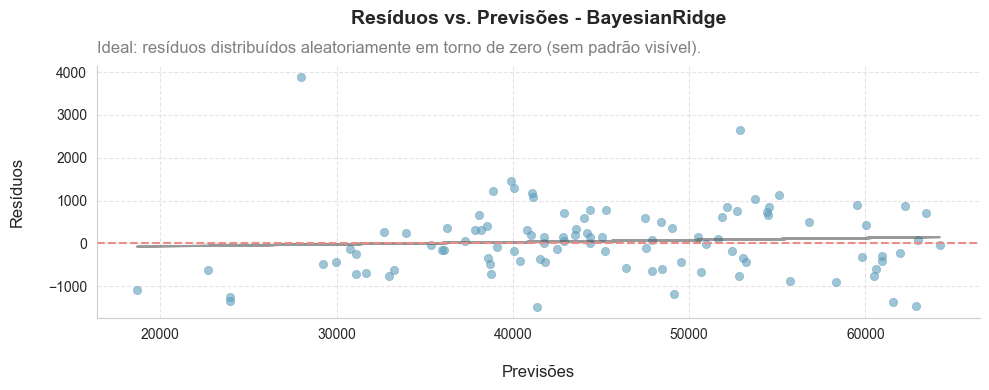

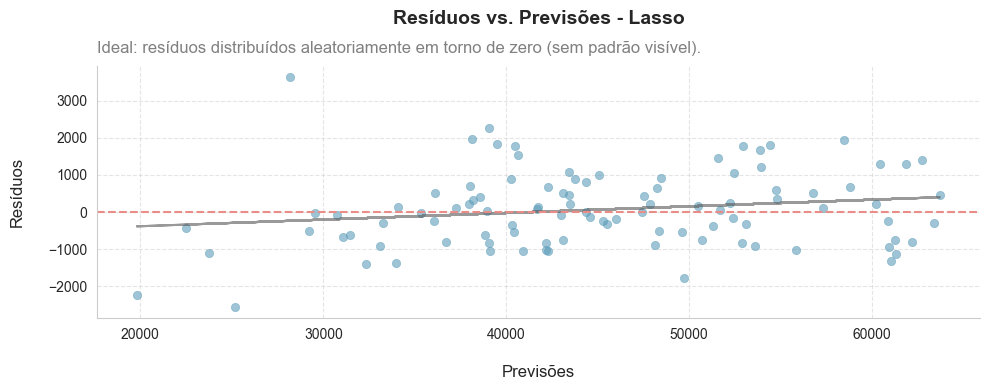

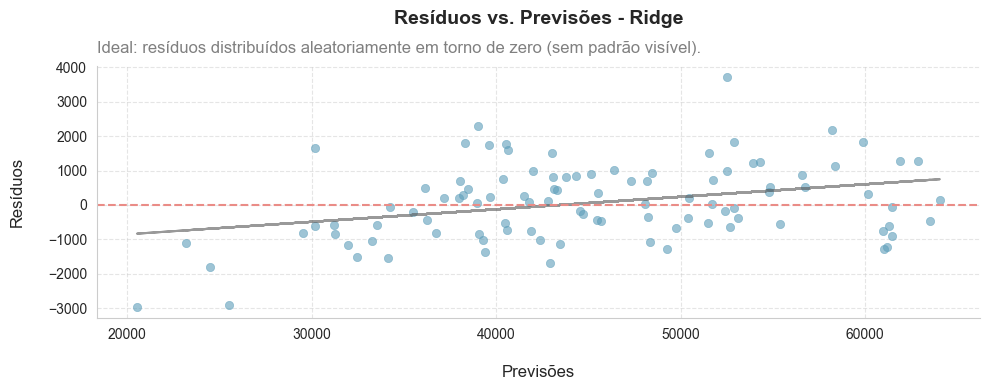

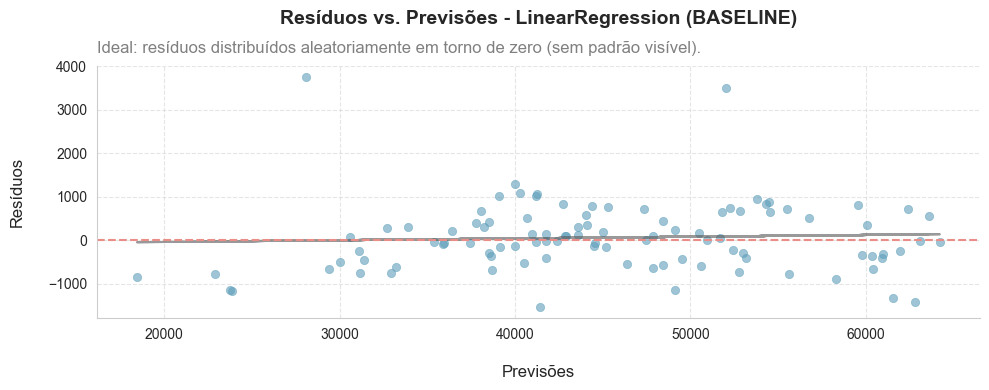

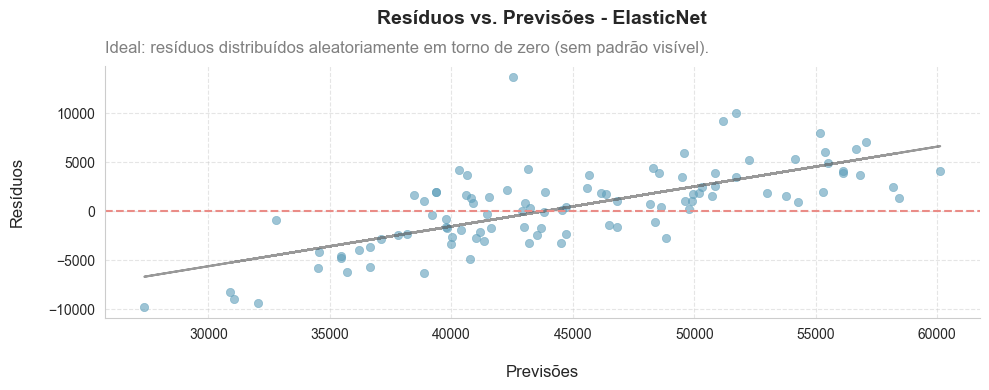

In [123]:
# Ordenar modelos pelos menores Final_Score
sorted_models = df_ranked.sort_values('Final_Score')['Model'].tolist()

# Loop para ajustar cada modelo e gerar o gráfico de resíduos
for model_name in sorted_models:
    
    # Seleção do modelo atual
    model = models[model_name]
    # Criação do pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Treinamento do pipeline com os dados de treino
    pipeline.fit(X_train, y_train)
    # Geração das previsões com os dados de teste
    preds = pipeline.predict(X_test)
    # Cálculo dos resíduos (diferença entre valor real e previsto)
    residuals = y_test - preds

    # Ajuste do tamanho da figura
    fig, ax = plt.subplots(figsize=(10, 4))

    # Gráfico de dispersão dos resíduos em função das previsões
    sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6, edgecolor=None, ax=ax)

    # Linha de tendência dos resíduos
    trend_model = LinearRegression()
    trend_model.fit(preds.reshape(-1, 1), residuals)
    trend_line = trend_model.predict(preds.reshape(-1, 1))
    ax.plot(preds, trend_line, color='#555555', linestyle='-', linewidth=1.5, alpha=0.6)

    # Linha horizontal representando o ponto de resíduo zero
    ax.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)

    # Título do gráfico com destaque
    ax.set_title(f'Resíduos vs. Previsões - {model_name}\n', fontsize=14, fontweight='bold', pad=15)  
    # Rótulo do eixo X
    ax.set_xlabel('\nPrevisões', fontsize=12)
    # Rótulo do eixo Y
    ax.set_ylabel('Resíduos\n', fontsize=12)

    # Subtítulo explicativo
    ax.text(0, 1.05, 
        'Ideal: resíduos distribuídos aleatoriamente em torno de zero (sem padrão visível).',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)
    
    # Exibição da grade para melhor leitura dos dados
    ax.grid(True, linestyle='--', alpha=0.5)
    # Ajuste dos tamanhos dos ticks
    ax.tick_params(labelsize=10)
    # Remover bordas desnecessárias
    sns.despine(right=True, top=True)

    # Ajuste final do layout para evitar sobreposição
    fig.tight_layout()
    # Exibição do gráfico
    plt.show()


### 4.4. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.4.1. Ajustes de parâmetros globais para os modelos

In [124]:
def set_global_seed(seed=42):
    '''
    Define uma semente global para garantir reprodutibilidade em operações
    envolvendo geração de números aleatórios.

    :param seed: int, default=42
        Valor da semente que será aplicada globalmente.

    :return: None
        Não retorna valores. Apenas configura o ambiente.
    '''

    # Seed para NumPy
    np.random.seed(seed)

    # Seed para random (biblioteca padrão do Python)
    random.seed(seed)

    # Seed para hashing interno do Python
    os.environ['PYTHONHASHSEED'] = str(seed)


In [125]:
# Validação cruzada estável (50 folds = 5x10)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Usamos MAE negativo porque Optuna minimiza a função de objetivo
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

#### 4.4.2. Tunagem do modelo **Bayesian Ridge**

In [126]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 300, 1500),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-5, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-5, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-5, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-5, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [127]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-04 20:51:15,737] A new study created in memory with name: no-name-588d51d9-32e6-4ef4-a49d-d2159a01d1a3
Best trial: 0. Best value: 638.908:   1%|          | 1/100 [00:01<01:47,  1.08s/it, 1.08/1800 seconds]

[I 2025-12-04 20:51:16,818] Trial 0 finished with value: 638.9082092024622 and parameters: {'max_iter': 1464, 'tol': 2.810584820414675e-05, 'alpha_1': 9.458483287808929e-06, 'alpha_2': 2.193277218855519e-08, 'lambda_1': 3.571198539497972e-08, 'lambda_2': 1.0270478371311966e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:   5%|▌         | 5/100 [00:01<00:17,  5.37it/s, 1.39/1800 seconds]

[I 2025-12-04 20:51:17,002] Trial 1 finished with value: 638.9082106425444 and parameters: {'max_iter': 497, 'tol': 0.0007246788269074784, 'alpha_1': 1.3886699921446122e-07, 'alpha_2': 5.043065004931711e-06, 'lambda_1': 6.613789224442489e-07, 'lambda_2': 3.074488645386977e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:17,028] Trial 3 finished with value: 638.9082100848394 and parameters: {'max_iter': 1314, 'tol': 5.047150127853352e-05, 'alpha_1': 3.170812335534552e-08, 'alpha_2': 1.0053137915277853e-06, 'lambda_1': 6.856660250545976e-08, 'lambda_2': 2.435055814968105e-06}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:17,052] Trial 2 finished with value: 638.9082143698954 and parameters: {'max_iter': 769, 'tol': 1.3337828277977368e-06, 'alpha_1': 2.377390365234046e-08, 'alpha_2': 5.309262001461988e-07, 'lambda_1': 4.731811736594225e-06, 'lambda_2': 2.9349399456340283e-08}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:

Best trial: 0. Best value: 638.908:   6%|▌         | 6/100 [00:01<00:17,  5.37it/s, 1.82/1800 seconds]

[I 2025-12-04 20:51:17,553] Trial 5 finished with value: 638.9082100751356 and parameters: {'max_iter': 1473, 'tol': 1.3338201109033839e-06, 'alpha_1': 1.0831907657087854e-08, 'alpha_2': 1.5655026147524114e-08, 'lambda_1': 5.848474530447297e-08, 'lambda_2': 1.306073112453135e-06}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:   7%|▋         | 7/100 [00:02<00:27,  3.34it/s, 2.32/1800 seconds]

[I 2025-12-04 20:51:18,045] Trial 7 finished with value: 638.9082100383856 and parameters: {'max_iter': 1195, 'tol': 0.00017620050474535483, 'alpha_1': 3.253624302865181e-07, 'alpha_2': 4.902026205156781e-06, 'lambda_1': 3.9232283826757425e-08, 'lambda_2': 3.6028040167095767e-06}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  10%|█         | 10/100 [00:02<00:24,  3.64it/s, 2.86/1800 seconds]

[I 2025-12-04 20:51:18,440] Trial 6 finished with value: 638.9082108971193 and parameters: {'max_iter': 1483, 'tol': 1.1272655375319249e-06, 'alpha_1': 5.442534324741698e-07, 'alpha_2': 3.343836013161433e-08, 'lambda_1': 1.0050773580833385e-06, 'lambda_2': 1.1109597481116607e-08}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:18,589] Trial 8 finished with value: 638.908210388193 and parameters: {'max_iter': 755, 'tol': 5.75662157644453e-06, 'alpha_1': 2.841731394568056e-07, 'alpha_2': 5.093298975411484e-07, 'lambda_1': 4.256469120335333e-07, 'lambda_2': 6.852712724967868e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:18,589] Trial 9 finished with value: 638.9082103967902 and parameters: {'max_iter': 949, 'tol': 3.675570389428756e-06, 'alpha_1': 7.944103737492884e-08, 'alpha_2': 1.4688912939130376e-07, 'lambda_1': 4.1503493783488093e-07, 'lambda_2': 1.4124148241111282e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  11%|█         | 11/100 [00:03<00:17,  5.18it/s, 3.01/1800 seconds]

[I 2025-12-04 20:51:18,738] Trial 10 finished with value: 638.9082094150085 and parameters: {'max_iter': 377, 'tol': 0.0003708399995088614, 'alpha_1': 7.603744339042363e-06, 'alpha_2': 2.8558070635475724e-08, 'lambda_1': 6.685628489061893e-08, 'lambda_2': 1.347676690787106e-06}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  12%|█▏        | 12/100 [00:03<00:20,  4.20it/s, 3.37/1800 seconds]

[I 2025-12-04 20:51:19,045] Trial 11 finished with value: 638.908212639946 and parameters: {'max_iter': 1063, 'tol': 6.086158155835018e-05, 'alpha_1': 3.832286962496273e-06, 'alpha_2': 6.005372645584706e-06, 'lambda_1': 3.2206836519634174e-06, 'lambda_2': 1.4362117259816296e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  13%|█▎        | 13/100 [00:03<00:22,  3.90it/s, 3.71/1800 seconds]

[I 2025-12-04 20:51:19,376] Trial 12 finished with value: 638.9082101027183 and parameters: {'max_iter': 905, 'tol': 5.591422308677596e-05, 'alpha_1': 1.585658166489494e-07, 'alpha_2': 7.819307056277258e-06, 'lambda_1': 9.985295790742574e-08, 'lambda_2': 4.049657199692012e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  15%|█▌        | 15/100 [00:04<00:19,  4.43it/s, 4.11/1800 seconds]

[I 2025-12-04 20:51:19,700] Trial 15 finished with value: 638.9082092333377 and parameters: {'max_iter': 332, 'tol': 1.997189103426339e-05, 'alpha_1': 8.890089845127267e-06, 'alpha_2': 7.767012713188208e-08, 'lambda_1': 1.4017532504906574e-08, 'lambda_2': 1.0167195162124413e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:19,846] Trial 13 finished with value: 638.9082096736049 and parameters: {'max_iter': 1481, 'tol': 1.710652540910613e-05, 'alpha_1': 4.236187489972768e-06, 'alpha_2': 1.856363981245386e-06, 'lambda_1': 3.5982460544306004e-08, 'lambda_2': 1.0092183873729665e-06}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  17%|█▋        | 17/100 [00:04<00:14,  5.55it/s, 4.37/1800 seconds]

[I 2025-12-04 20:51:19,960] Trial 14 finished with value: 638.9082092956193 and parameters: {'max_iter': 1018, 'tol': 2.145717576857974e-05, 'alpha_1': 8.1716411952821e-06, 'alpha_2': 7.02191684891944e-08, 'lambda_1': 1.1094610438455815e-08, 'lambda_2': 1.1442212891200096e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:20,108] Trial 16 finished with value: 638.9082092179074 and parameters: {'max_iter': 321, 'tol': 2.8463137829055777e-05, 'alpha_1': 9.10113950325618e-06, 'alpha_2': 6.457343299556273e-08, 'lambda_1': 1.7415751550563536e-08, 'lambda_2': 1.2791859077814197e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  18%|█▊        | 18/100 [00:04<00:24,  3.39it/s, 4.95/1800 seconds]

[I 2025-12-04 20:51:20,665] Trial 17 finished with value: 638.9082095990708 and parameters: {'max_iter': 303, 'tol': 1.4152915331005333e-05, 'alpha_1': 4.8096894445715585e-06, 'alpha_2': 6.468031507810075e-08, 'lambda_1': 1.1286214857134341e-08, 'lambda_2': 1.8671660859513832e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  20%|██        | 20/100 [00:05<00:24,  3.23it/s, 5.39/1800 seconds]

[I 2025-12-04 20:51:20,960] Trial 18 finished with value: 638.9082092760685 and parameters: {'max_iter': 329, 'tol': 1.7410076274713302e-05, 'alpha_1': 8.375274639699902e-06, 'alpha_2': 7.130120861994493e-08, 'lambda_1': 1.002358967986777e-08, 'lambda_2': 1.1088734330430345e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:21,120] Trial 19 finished with value: 638.9082098791198 and parameters: {'max_iter': 592, 'tol': 1.2975321477170041e-05, 'alpha_1': 1.6993320056404892e-06, 'alpha_2': 9.075650080177376e-08, 'lambda_1': 1.0493941017548601e-08, 'lambda_2': 9.546464498678234e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  21%|██        | 21/100 [00:05<00:17,  4.60it/s, 5.51/1800 seconds]

[I 2025-12-04 20:51:21,242] Trial 20 finished with value: 638.9082098920188 and parameters: {'max_iter': 597, 'tol': 1.2623859188796379e-05, 'alpha_1': 1.575166928416791e-06, 'alpha_2': 1.02339076557331e-07, 'lambda_1': 1.2318767123001078e-08, 'lambda_2': 8.168446033514968e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  23%|██▎       | 23/100 [00:05<00:16,  4.70it/s, 5.79/1800 seconds]

[I 2025-12-04 20:51:21,441] Trial 21 finished with value: 638.9082099159341 and parameters: {'max_iter': 584, 'tol': 8.93349368073794e-06, 'alpha_1': 1.2872866916119036e-06, 'alpha_2': 1.4902936199998911e-07, 'lambda_1': 1.0341645949435257e-08, 'lambda_2': 1.0331928922040173e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:21,527] Trial 22 finished with value: 638.9082101080108 and parameters: {'max_iter': 603, 'tol': 7.84645649169322e-06, 'alpha_1': 1.2348100329836227e-06, 'alpha_2': 1.1382872356023901e-08, 'lambda_1': 2.1417337978754261e-07, 'lambda_2': 8.775088581565663e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  24%|██▍       | 24/100 [00:06<00:20,  3.76it/s, 6.39/1800 seconds]

[I 2025-12-04 20:51:22,113] Trial 23 finished with value: 638.9082100405357 and parameters: {'max_iter': 570, 'tol': 7.1584019911537255e-06, 'alpha_1': 1.3328379176507303e-06, 'alpha_2': 1.0382091031379853e-08, 'lambda_1': 1.5039465302803097e-07, 'lambda_2': 6.067333863545048e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  25%|██▌       | 25/100 [00:06<00:20,  3.67it/s, 6.68/1800 seconds]

[I 2025-12-04 20:51:22,403] Trial 24 finished with value: 638.9082100580124 and parameters: {'max_iter': 583, 'tol': 6.384170483178777e-06, 'alpha_1': 1.5487700992383468e-06, 'alpha_2': 1.569666724987474e-08, 'lambda_1': 1.9066969659821917e-07, 'lambda_2': 4.4501541393177606e-08}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:22,594] Trial 25 finished with value: 638.9082100288939 and parameters: {'max_iter': 754, 'tol': 5.946997311887028e-06, 'alpha_1': 1.4659805533491113e-06, 'alpha_2': 1.568619189072332e-08, 'lambda_1': 1.508713059435389e-07, 'lambda_2': 4.004682056934959e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  27%|██▋       | 27/100 [00:06<00:15,  4.69it/s, 6.97/1800 seconds]

[I 2025-12-04 20:51:22,709] Trial 26 finished with value: 638.9082098591412 and parameters: {'max_iter': 453, 'tol': 6.382097051047849e-06, 'alpha_1': 2.0870577721645756e-06, 'alpha_2': 1.1030091649219742e-08, 'lambda_1': 2.718413162553642e-08, 'lambda_2': 3.5199448672411375e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  29%|██▉       | 29/100 [00:07<00:15,  4.45it/s, 7.25/1800 seconds]

[I 2025-12-04 20:51:22,961] Trial 27 finished with value: 638.9082098181067 and parameters: {'max_iter': 451, 'tol': 2.957919189528376e-05, 'alpha_1': 2.547172399696767e-06, 'alpha_2': 1.0741212349552223e-08, 'lambda_1': 2.6525607689659195e-08, 'lambda_2': 3.089481979175903e-08}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:22,975] Trial 28 finished with value: 638.9082097899009 and parameters: {'max_iter': 444, 'tol': 8.771347902729434e-05, 'alpha_1': 2.9393671939290224e-06, 'alpha_2': 3.0990509144813817e-08, 'lambda_1': 3.1669735129342967e-08, 'lambda_2': 4.1512201798774624e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  30%|███       | 30/100 [00:08<00:21,  3.24it/s, 8.02/1800 seconds]

[I 2025-12-04 20:51:23,751] Trial 29 finished with value: 638.9082097864255 and parameters: {'max_iter': 442, 'tol': 3.048009070659761e-05, 'alpha_1': 2.911771144787798e-06, 'alpha_2': 2.9041002576546444e-08, 'lambda_1': 2.785875697699684e-08, 'lambda_2': 3.9810587800425756e-08}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  32%|███▏      | 32/100 [00:08<00:18,  3.76it/s, 8.50/1800 seconds]

[I 2025-12-04 20:51:24,086] Trial 30 finished with value: 638.908209743313 and parameters: {'max_iter': 440, 'tol': 3.3978679884417685e-05, 'alpha_1': 3.4058943072776062e-06, 'alpha_2': 3.462528257794419e-08, 'lambda_1': 2.9522543665603796e-08, 'lambda_2': 2.3335657421829048e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:24,243] Trial 31 finished with value: 638.9082097943981 and parameters: {'max_iter': 411, 'tol': 3.471624872597233e-05, 'alpha_1': 2.785643213664907e-06, 'alpha_2': 2.7430492560868212e-08, 'lambda_1': 2.3997648309088875e-08, 'lambda_2': 2.142713469021574e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 0. Best value: 638.908:  33%|███▎      | 33/100 [00:08<00:15,  4.25it/s, 8.66/1800 seconds]

[I 2025-12-04 20:51:24,388] Trial 32 finished with value: 638.9082097123801 and parameters: {'max_iter': 423, 'tol': 3.0882587824279554e-05, 'alpha_1': 3.678239055489054e-06, 'alpha_2': 3.609090808242872e-08, 'lambda_1': 2.260442512590572e-08, 'lambda_2': 2.7076666738704653e-07}. Best is trial 0 with value: 638.9082092024622.


Best trial: 33. Best value: 638.908:  35%|███▌      | 35/100 [00:08<00:15,  4.29it/s, 8.90/1800 seconds]

[I 2025-12-04 20:51:24,620] Trial 34 finished with value: 638.9082099731027 and parameters: {'max_iter': 1164, 'tol': 3.638676012116675e-05, 'alpha_1': 7.569959579004831e-07, 'alpha_2': 2.875921055696539e-07, 'lambda_1': 1.915224491185178e-08, 'lambda_2': 2.3691953917206585e-07}. Best is trial 0 with value: 638.9082092024622.
[I 2025-12-04 20:51:24,630] Trial 33 finished with value: 638.9082091515756 and parameters: {'max_iter': 1096, 'tol': 7.550627159726703e-05, 'alpha_1': 9.879117346780176e-06, 'alpha_2': 3.8737829502262176e-08, 'lambda_1': 1.9181157284868164e-08, 'lambda_2': 2.1724353742242205e-07}. Best is trial 33 with value: 638.9082091515756.


Best trial: 33. Best value: 638.908:  37%|███▋      | 37/100 [00:09<00:17,  3.58it/s, 9.90/1800 seconds]

[I 2025-12-04 20:51:25,528] Trial 35 finished with value: 638.9082091533168 and parameters: {'max_iter': 1133, 'tol': 0.00012379219893455176, 'alpha_1': 9.856002726726737e-06, 'alpha_2': 2.1953529917372036e-07, 'lambda_1': 1.7321198271342485e-08, 'lambda_2': 2.9613513695089797e-07}. Best is trial 33 with value: 638.9082091515756.
[I 2025-12-04 20:51:25,628] Trial 36 finished with value: 638.9082091747918 and parameters: {'max_iter': 311, 'tol': 9.782246635843051e-05, 'alpha_1': 9.61831980616643e-06, 'alpha_2': 2.0349078423194082e-07, 'lambda_1': 1.850346239789879e-08, 'lambda_2': 3.48767674822846e-07}. Best is trial 33 with value: 638.9082091515756.


Best trial: 33. Best value: 638.908:  38%|███▊      | 38/100 [00:10<00:16,  3.85it/s, 10.11/1800 seconds]

[I 2025-12-04 20:51:25,848] Trial 37 finished with value: 638.9082095735233 and parameters: {'max_iter': 333, 'tol': 9.89413627582088e-05, 'alpha_1': 5.196589685193576e-06, 'alpha_2': 1.7904397979424874e-07, 'lambda_1': 1.7938906706250065e-08, 'lambda_2': 1.4521405909247503e-07}. Best is trial 33 with value: 638.9082091515756.


Best trial: 33. Best value: 638.908:  39%|███▉      | 39/100 [00:10<00:15,  3.82it/s, 10.38/1800 seconds]

[I 2025-12-04 20:51:26,111] Trial 38 finished with value: 638.9082094265366 and parameters: {'max_iter': 308, 'tol': 2.080230119766638e-05, 'alpha_1': 6.7823932738542515e-06, 'alpha_2': 2.126490929806502e-07, 'lambda_1': 1.7047903347635534e-08, 'lambda_2': 4.021270180527977e-07}. Best is trial 33 with value: 638.9082091515756.


Best trial: 39. Best value: 638.908:  41%|████      | 41/100 [00:10<00:14,  4.00it/s, 10.64/1800 seconds]

[I 2025-12-04 20:51:26,328] Trial 39 finished with value: 638.9082091511958 and parameters: {'max_iter': 1354, 'tol': 0.00010380437553407764, 'alpha_1': 9.877595071922111e-06, 'alpha_2': 2.4751334780489114e-07, 'lambda_1': 1.7601312333989816e-08, 'lambda_2': 3.7808982086043624e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:26,361] Trial 40 finished with value: 638.9082095173832 and parameters: {'max_iter': 1321, 'tol': 0.00010938509024636005, 'alpha_1': 5.8079809575202955e-06, 'alpha_2': 1.8686271702340977e-07, 'lambda_1': 1.5931188394641874e-08, 'lambda_2': 4.774639260444288e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  43%|████▎     | 43/100 [00:11<00:17,  3.24it/s, 11.73/1800 seconds]

[I 2025-12-04 20:51:27,316] Trial 41 finished with value: 638.908209522137 and parameters: {'max_iter': 1378, 'tol': 0.00010823224768877607, 'alpha_1': 6.13272204365119e-06, 'alpha_2': 2.0792465289129866e-07, 'lambda_1': 5.334958286399968e-08, 'lambda_2': 4.173015704302123e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:27,467] Trial 42 finished with value: 638.9082105689392 and parameters: {'max_iter': 1373, 'tol': 0.00015111160240438847, 'alpha_1': 5.23665651978517e-06, 'alpha_2': 2.6102225538713844e-07, 'lambda_1': 1.1008264648552563e-06, 'lambda_2': 4.354751083097973e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  44%|████▍     | 44/100 [00:11<00:15,  3.60it/s, 11.92/1800 seconds]

[I 2025-12-04 20:51:27,662] Trial 43 finished with value: 638.9082095757819 and parameters: {'max_iter': 1374, 'tol': 0.0002084407825257187, 'alpha_1': 5.561124262215933e-06, 'alpha_2': 1.0425934787513305e-06, 'lambda_1': 5.040399487319405e-08, 'lambda_2': 4.5078025301441283e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  46%|████▌     | 46/100 [00:12<00:14,  3.82it/s, 12.45/1800 seconds]

[I 2025-12-04 20:51:28,018] Trial 44 finished with value: 638.9082095447363 and parameters: {'max_iter': 1388, 'tol': 0.00022339932699841123, 'alpha_1': 5.925141960947359e-06, 'alpha_2': 1.08251631327837e-06, 'lambda_1': 5.241784539188426e-08, 'lambda_2': 5.888994434123735e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:28,183] Trial 45 finished with value: 638.9082095460506 and parameters: {'max_iter': 1294, 'tol': 0.000221320104174165, 'alpha_1': 5.8751817456582135e-06, 'alpha_2': 8.385720823909875e-07, 'lambda_1': 4.893517183339334e-08, 'lambda_2': 5.795446602272339e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  47%|████▋     | 47/100 [00:12<00:13,  3.82it/s, 12.54/1800 seconds]

[I 2025-12-04 20:51:28,281] Trial 46 finished with value: 638.90820955619 and parameters: {'max_iter': 1405, 'tol': 0.0002140479697414137, 'alpha_1': 5.812186893988047e-06, 'alpha_2': 7.811423104761009e-07, 'lambda_1': 5.375389146774985e-08, 'lambda_2': 6.640421547513339e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  48%|████▊     | 48/100 [00:13<00:17,  2.93it/s, 13.33/1800 seconds]

[I 2025-12-04 20:51:29,067] Trial 47 finished with value: 638.9082104015529 and parameters: {'max_iter': 1205, 'tol': 0.00031922237608049344, 'alpha_1': 5.4648853566897955e-06, 'alpha_2': 1.1228977208076587e-06, 'lambda_1': 9.325415332984316e-07, 'lambda_2': 7.99601554329849e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  50%|█████     | 50/100 [00:13<00:16,  3.05it/s, 13.69/1800 seconds]

[I 2025-12-04 20:51:29,310] Trial 48 finished with value: 638.908210077676 and parameters: {'max_iter': 1221, 'tol': 0.0003203217324280797, 'alpha_1': 3.9028486178410483e-08, 'alpha_2': 4.807473141698923e-07, 'lambda_1': 4.737281576081895e-08, 'lambda_2': 6.902612162958028e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:29,428] Trial 49 finished with value: 638.9082180842463 and parameters: {'max_iter': 1189, 'tol': 0.00034071008134676904, 'alpha_1': 9.48611531301929e-06, 'alpha_2': 4.5105773548997124e-07, 'lambda_1': 9.68747775015703e-06, 'lambda_2': 7.219738858024319e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  53%|█████▎    | 53/100 [00:14<00:14,  3.31it/s, 14.23/1800 seconds]

[I 2025-12-04 20:51:29,881] Trial 50 finished with value: 638.9082092801772 and parameters: {'max_iter': 1229, 'tol': 0.0003871610975096347, 'alpha_1': 9.215884520062702e-06, 'alpha_2': 4.3829800712390406e-07, 'lambda_1': 7.396382074821161e-08, 'lambda_2': 6.25897467491268e-06}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:29,957] Trial 51 finished with value: 638.9082092378779 and parameters: {'max_iter': 1209, 'tol': 0.0007943623654575567, 'alpha_1': 9.869529995422249e-06, 'alpha_2': 4.0731136300590777e-07, 'lambda_1': 7.729707756629135e-08, 'lambda_2': 9.364404795905893e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:29,971] Trial 52 finished with value: 638.9082101302022 and parameters: {'max_iter': 1204, 'tol': 0.000488777312023205, 'alpha_1': 4.5680591746132856e-08, 'alpha_2': 4.370189821459219e-07, 'lambda_1': 9.468128253106012e-08, 'lambda_2': 9.377224645863405e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  55%|█████▌    | 55/100 [00:15<00:12,  3.50it/s, 15.30/1800 seconds]

[I 2025-12-04 20:51:30,934] Trial 53 finished with value: 638.9082092647509 and parameters: {'max_iter': 1078, 'tol': 6.14771918798612e-05, 'alpha_1': 9.335777920418327e-06, 'alpha_2': 4.6204275370918914e-07, 'lambda_1': 8.951004764633099e-08, 'lambda_2': 8.869224493499526e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:31,040] Trial 54 finished with value: 638.9082100144326 and parameters: {'max_iter': 1085, 'tol': 6.789416626405821e-05, 'alpha_1': 9.119258830417715e-07, 'alpha_2': 3.5846035769880834e-07, 'lambda_1': 7.737862468976903e-08, 'lambda_2': 9.99215577609624e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  58%|█████▊    | 58/100 [00:15<00:10,  3.85it/s, 15.54/1800 seconds]

[I 2025-12-04 20:51:31,203] Trial 57 finished with value: 638.9082093947999 and parameters: {'max_iter': 1090, 'tol': 6.780567134133064e-05, 'alpha_1': 7.186240541853634e-06, 'alpha_2': 5.167973411487743e-08, 'lambda_1': 1.9621363960867026e-08, 'lambda_2': 1.7125454005128475e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:31,250] Trial 58 finished with value: 638.9082093951494 and parameters: {'max_iter': 1097, 'tol': 6.749283548775863e-05, 'alpha_1': 7.3641649518321465e-06, 'alpha_2': 4.941241715404758e-08, 'lambda_1': 3.7464888985979804e-08, 'lambda_2': 1.5323601770115896e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:31,273] Trial 55 finished with value: 638.9082091812339 and parameters: {'max_iter': 1075, 'tol': 7.093934946258567e-05, 'alpha_1': 9.734657511455825e-06, 'alpha_2': 4.83909476960193e-08, 'lambda_1': 3.725684636011505e-08, 'lambda_2': 9.787984049413594e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  59%|█████▉    | 59/100 [00:16<00:09,  4.34it/s, 16.05/1800 seconds]

[I 2025-12-04 20:51:31,759] Trial 56 finished with value: 638.9082092311259 and parameters: {'max_iter': 1109, 'tol': 7.159967532217773e-05, 'alpha_1': 9.004720477487545e-06, 'alpha_2': 4.5766455271705866e-08, 'lambda_1': 1.9842677434682556e-08, 'lambda_2': 1.5435738337377893e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  62%|██████▏   | 62/100 [00:17<00:11,  3.21it/s, 17.17/1800 seconds]

[I 2025-12-04 20:51:32,749] Trial 59 finished with value: 638.9082100399593 and parameters: {'max_iter': 848, 'tol': 7.460970158415015e-05, 'alpha_1': 2.3702214378169627e-07, 'alpha_2': 4.915624024281827e-08, 'lambda_1': 3.853042449376395e-08, 'lambda_2': 1.6672664806787045e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:32,864] Trial 60 finished with value: 638.908210015468 and parameters: {'max_iter': 953, 'tol': 4.4162073182156077e-05, 'alpha_1': 2.443282714818275e-07, 'alpha_2': 4.884779675259977e-08, 'lambda_1': 1.4344729963641895e-08, 'lambda_2': 1.6610976474814366e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:32,905] Trial 61 finished with value: 638.9082096703362 and parameters: {'max_iter': 817, 'tol': 4.4215003193397894e-05, 'alpha_1': 4.065546513213455e-06, 'alpha_2': 2.1778559491457252e-08, 'lambda_1': 1.425447725258908e-08, 'lambda_2': 2.9904761032007356e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  64%|██████▍   | 64/100 [00:17<00:08,  4.39it/s, 17.36/1800 seconds]

[I 2025-12-04 20:51:33,038] Trial 63 finished with value: 638.9082097009534 and parameters: {'max_iter': 991, 'tol': 0.00014710014480872512, 'alpha_1': 3.7890654778577914e-06, 'alpha_2': 1.1408901074121069e-07, 'lambda_1': 1.44691621796452e-08, 'lambda_2': 2.158469618210556e-06}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:33,082] Trial 62 finished with value: 638.9082100145287 and parameters: {'max_iter': 944, 'tol': 0.00015417638557803246, 'alpha_1': 3.155101865233942e-07, 'alpha_2': 1.1029289094071429e-07, 'lambda_1': 1.3848823436523328e-08, 'lambda_2': 3.039128049697152e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  65%|██████▌   | 65/100 [00:17<00:07,  4.80it/s, 17.64/1800 seconds]

[I 2025-12-04 20:51:33,382] Trial 64 finished with value: 638.9082100256261 and parameters: {'max_iter': 954, 'tol': 0.00013553951577076678, 'alpha_1': 3.845468233742162e-07, 'alpha_2': 1.1109903772315369e-07, 'lambda_1': 3.456976482642894e-08, 'lambda_2': 1.4037408862407053e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  66%|██████▌   | 66/100 [00:18<00:08,  3.86it/s, 18.11/1800 seconds]

[I 2025-12-04 20:51:33,824] Trial 65 finished with value: 638.9082100355231 and parameters: {'max_iter': 946, 'tol': 4.915173075556884e-05, 'alpha_1': 1.5613124521259634e-08, 'alpha_2': 1.0976642555048868e-07, 'lambda_1': 1.3827294827589107e-08, 'lambda_2': 2.1956041736045274e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  67%|██████▋   | 67/100 [00:18<00:08,  3.78it/s, 18.39/1800 seconds]

[I 2025-12-04 20:51:34,127] Trial 66 finished with value: 638.9082096357818 and parameters: {'max_iter': 1027, 'tol': 0.00013455054244203044, 'alpha_1': 4.478641068336994e-06, 'alpha_2': 1.1122266639279159e-07, 'lambda_1': 1.2620462713895612e-08, 'lambda_2': 1.890245198166631e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  69%|██████▉   | 69/100 [00:19<00:09,  3.12it/s, 19.29/1800 seconds]

[I 2025-12-04 20:51:34,873] Trial 67 finished with value: 638.9082096364432 and parameters: {'max_iter': 1014, 'tol': 3.0640574216115096e-06, 'alpha_1': 4.410237617592887e-06, 'alpha_2': 1.1892500717248333e-07, 'lambda_1': 1.330260182108249e-08, 'lambda_2': 1.524707136362333e-06}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:35,023] Trial 68 finished with value: 638.9082093962668 and parameters: {'max_iter': 1498, 'tol': 1.9138434841830527e-06, 'alpha_1': 7.287364140823304e-06, 'alpha_2': 1.3795478555662803e-07, 'lambda_1': 3.46581365387945e-08, 'lambda_2': 3.1333586896559833e-06}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  71%|███████   | 71/100 [00:19<00:06,  4.44it/s, 19.47/1800 seconds]

[I 2025-12-04 20:51:35,082] Trial 69 finished with value: 638.9082093713173 and parameters: {'max_iter': 1434, 'tol': 0.00012643615493485656, 'alpha_1': 7.601061008956952e-06, 'alpha_2': 1.3966442981777084e-07, 'lambda_1': 3.2823342799616816e-08, 'lambda_2': 1.5023824502294655e-06}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:35,209] Trial 70 finished with value: 638.9082100440722 and parameters: {'max_iter': 1433, 'tol': 4.932474513988884e-05, 'alpha_1': 1.4562879162139947e-08, 'alpha_2': 2.21849580123556e-08, 'lambda_1': 2.3013095658168604e-08, 'lambda_2': 5.963126225148939e-08}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  73%|███████▎  | 73/100 [00:20<00:06,  4.17it/s, 19.84/1800 seconds]

[I 2025-12-04 20:51:35,574] Trial 71 finished with value: 638.9082098508824 and parameters: {'max_iter': 1139, 'tol': 2.6872193520552613e-05, 'alpha_1': 2.153708955477155e-06, 'alpha_2': 1.511438148109796e-07, 'lambda_1': 2.3591719455809926e-08, 'lambda_2': 5.371082488203876e-08}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:35,749] Trial 72 finished with value: 638.9082094229179 and parameters: {'max_iter': 1437, 'tol': 2.4727915093225407e-05, 'alpha_1': 6.904429340922215e-06, 'alpha_2': 2.056925529609031e-08, 'lambda_1': 2.4918151162257523e-08, 'lambda_2': 6.988120116243885e-08}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  74%|███████▍  | 74/100 [00:20<00:09,  2.88it/s, 20.68/1800 seconds]

[I 2025-12-04 20:51:36,415] Trial 73 finished with value: 638.9082093682696 and parameters: {'max_iter': 1499, 'tol': 2.444308676618575e-05, 'alpha_1': 7.517947816772234e-06, 'alpha_2': 1.820486410818299e-08, 'lambda_1': 2.5733742992969784e-08, 'lambda_2': 5.8956617232268594e-08}. Best is trial 39 with value: 638.9082091511958.


Best trial: 39. Best value: 638.908:  77%|███████▋  | 77/100 [00:21<00:04,  4.80it/s, 21.04/1800 seconds]

[I 2025-12-04 20:51:36,607] Trial 74 finished with value: 638.9082098544504 and parameters: {'max_iter': 1438, 'tol': 8.542724488906307e-05, 'alpha_1': 2.127754744404605e-06, 'alpha_2': 2.215825051716531e-08, 'lambda_1': 2.2187854721182863e-08, 'lambda_2': 7.413268411367263e-08}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:36,643] Trial 75 finished with value: 638.9082098509698 and parameters: {'max_iter': 506, 'tol': 2.5909661043964154e-05, 'alpha_1': 2.1496725321597113e-06, 'alpha_2': 2.175615179356632e-08, 'lambda_1': 2.337807807449033e-08, 'lambda_2': 6.329503726135098e-08}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:36,766] Trial 76 finished with value: 638.9082091589753 and parameters: {'max_iter': 1125, 'tol': 9.173262584059358e-05, 'alpha_1': 9.820549958191789e-06, 'alpha_2': 8.458953024484915e-08, 'lambda_1': 2.1217389462504407e-08, 'lambda_2': 3.4783158792827897e-07}. Best is trial 39 with value: 638.9082091511958.


Best trial: 78. Best value: 638.908:  79%|███████▉  | 79/100 [00:21<00:04,  4.45it/s, 21.37/1800 seconds]

[I 2025-12-04 20:51:37,107] Trial 77 finished with value: 638.9082093045829 and parameters: {'max_iter': 523, 'tol': 9.420244932363908e-05, 'alpha_1': 8.188475789773774e-06, 'alpha_2': 6.068144341597274e-08, 'lambda_1': 1.924959186403675e-08, 'lambda_2': 1.236745124848815e-07}. Best is trial 39 with value: 638.9082091511958.
[I 2025-12-04 20:51:37,277] Trial 78 finished with value: 638.9082091445352 and parameters: {'max_iter': 710, 'tol': 9.06687670010372e-05, 'alpha_1': 9.946852176639851e-06, 'alpha_2': 4.018403064079575e-08, 'lambda_1': 1.7920047997255702e-08, 'lambda_2': 1.2611966653838264e-07}. Best is trial 78 with value: 638.9082091445352.


Best trial: 78. Best value: 638.908:  80%|████████  | 80/100 [00:21<00:04,  4.14it/s, 21.85/1800 seconds]

[I 2025-12-04 20:51:37,584] Trial 80 finished with value: 638.9082091874873 and parameters: {'max_iter': 1125, 'tol': 8.398293954205308e-05, 'alpha_1': 9.472479609514523e-06, 'alpha_2': 3.998589680615734e-08, 'lambda_1': 1.807364716899188e-08, 'lambda_2': 1.231830599880488e-07}. Best is trial 78 with value: 638.9082091445352.


Best trial: 78. Best value: 638.908:  81%|████████  | 81/100 [00:22<00:05,  3.74it/s, 22.18/1800 seconds]

[I 2025-12-04 20:51:37,918] Trial 79 finished with value: 638.9082091554037 and parameters: {'max_iter': 656, 'tol': 9.3628801846481e-05, 'alpha_1': 9.839656287615282e-06, 'alpha_2': 4.1216270281203705e-08, 'lambda_1': 1.921491819115151e-08, 'lambda_2': 1.3610221375141655e-07}. Best is trial 78 with value: 638.9082091445352.


Best trial: 78. Best value: 638.908:  82%|████████▏ | 82/100 [00:22<00:05,  3.40it/s, 22.54/1800 seconds]

[I 2025-12-04 20:51:38,262] Trial 81 finished with value: 638.9082092845958 and parameters: {'max_iter': 368, 'tol': 4.153658641371229e-05, 'alpha_1': 8.38280872436913e-06, 'alpha_2': 4.2094426856651506e-08, 'lambda_1': 1.8795272491847867e-08, 'lambda_2': 1.1874402126221226e-07}. Best is trial 78 with value: 638.9082091445352.


Best trial: 78. Best value: 638.908:  83%|████████▎ | 83/100 [00:22<00:04,  3.73it/s, 22.75/1800 seconds]

[I 2025-12-04 20:51:38,462] Trial 82 finished with value: 638.9082091622465 and parameters: {'max_iter': 1331, 'tol': 1.6074836243937228e-05, 'alpha_1': 9.713241327190406e-06, 'alpha_2': 8.043408226029347e-08, 'lambda_1': 1.770842465903719e-08, 'lambda_2': 1.3062007251846708e-07}. Best is trial 78 with value: 638.9082091445352.


Best trial: 83. Best value: 638.908:  84%|████████▍ | 84/100 [00:23<00:04,  3.68it/s, 23.02/1800 seconds]

[I 2025-12-04 20:51:38,762] Trial 83 finished with value: 638.9082091431178 and parameters: {'max_iter': 657, 'tol': 1.043063164189048e-05, 'alpha_1': 9.91308398020744e-06, 'alpha_2': 8.460608078740444e-08, 'lambda_1': 1.674885500872921e-08, 'lambda_2': 2.227807263893614e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  85%|████████▌ | 85/100 [00:23<00:03,  3.86it/s, 23.26/1800 seconds]

[I 2025-12-04 20:51:38,992] Trial 84 finished with value: 638.9082100269125 and parameters: {'max_iter': 646, 'tol': 0.0001085164320371967, 'alpha_1': 1.1234137470470757e-07, 'alpha_2': 7.733548737407559e-08, 'lambda_1': 1.1120732507582462e-08, 'lambda_2': 3.4718494251067055e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  87%|████████▋ | 87/100 [00:23<00:03,  4.10it/s, 23.55/1800 seconds]

[I 2025-12-04 20:51:39,201] Trial 85 finished with value: 638.9082100307172 and parameters: {'max_iter': 668, 'tol': 0.0001825653159975448, 'alpha_1': 1.214147981340943e-07, 'alpha_2': 8.875782127127083e-08, 'lambda_1': 1.0843329033141007e-08, 'lambda_2': 3.4353779106371117e-07}. Best is trial 83 with value: 638.9082091431178.
[I 2025-12-04 20:51:39,286] Trial 86 finished with value: 638.9082094616244 and parameters: {'max_iter': 649, 'tol': 0.00018055788141755374, 'alpha_1': 6.417820613533662e-06, 'alpha_2': 3.927852715098153e-08, 'lambda_1': 1.0225856805736205e-08, 'lambda_2': 1.9670961349964268e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  88%|████████▊ | 88/100 [00:23<00:02,  4.02it/s, 23.97/1800 seconds]

[I 2025-12-04 20:51:39,705] Trial 87 finished with value: 638.9082091633868 and parameters: {'max_iter': 695, 'tol': 0.0001835082619740441, 'alpha_1': 9.726242534995352e-06, 'alpha_2': 7.810224222356701e-08, 'lambda_1': 1.0695335782901277e-08, 'lambda_2': 1.914561640094221e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  89%|████████▉ | 89/100 [00:24<00:03,  3.58it/s, 24.34/1800 seconds]

[I 2025-12-04 20:51:40,082] Trial 88 finished with value: 638.9082100330031 and parameters: {'max_iter': 680, 'tol': 0.00017596929888655987, 'alpha_1': 9.405979401756641e-08, 'alpha_2': 8.614515801539457e-08, 'lambda_1': 1.0631468010303097e-08, 'lambda_2': 3.586809373615843e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  91%|█████████ | 91/100 [00:24<00:02,  3.68it/s, 24.63/1800 seconds]

[I 2025-12-04 20:51:40,328] Trial 92 finished with value: 638.9082096025226 and parameters: {'max_iter': 713, 'tol': 1.0963384300429429e-05, 'alpha_1': 4.82029406067212e-06, 'alpha_2': 2.327236906761912e-07, 'lambda_1': 1.6243457529529766e-08, 'lambda_2': 2.66331279347316e-07}. Best is trial 83 with value: 638.9082091431178.
[I 2025-12-04 20:51:40,355] Trial 89 finished with value: 638.9082094606767 and parameters: {'max_iter': 1342, 'tol': 1.1355581667911811e-05, 'alpha_1': 6.334885326396308e-06, 'alpha_2': 8.40839701814168e-08, 'lambda_1': 1.0679417786959096e-08, 'lambda_2': 3.591738362552862e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  92%|█████████▏| 92/100 [00:24<00:01,  4.71it/s, 24.86/1800 seconds]

[I 2025-12-04 20:51:40,593] Trial 90 finished with value: 638.9082097707436 and parameters: {'max_iter': 692, 'tol': 0.00017083964377908754, 'alpha_1': 6.371715513604328e-06, 'alpha_2': 9.022871342739629e-08, 'lambda_1': 3.4250829690573283e-07, 'lambda_2': 2.0688191706303318e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  93%|█████████▎| 93/100 [00:25<00:01,  4.69it/s, 25.08/1800 seconds]

[I 2025-12-04 20:51:40,811] Trial 91 finished with value: 638.9082094559703 and parameters: {'max_iter': 721, 'tol': 1.6283934985775848e-05, 'alpha_1': 6.4425513610946034e-06, 'alpha_2': 2.2775978417634681e-07, 'lambda_1': 1.591805358265149e-08, 'lambda_2': 2.0792184703944603e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  94%|█████████▍| 94/100 [00:25<00:01,  4.20it/s, 25.39/1800 seconds]

[I 2025-12-04 20:51:41,126] Trial 93 finished with value: 638.9082096067415 and parameters: {'max_iter': 695, 'tol': 8.981292503731633e-06, 'alpha_1': 4.768513635507326e-06, 'alpha_2': 6.212275760403357e-08, 'lambda_1': 1.5901546182348684e-08, 'lambda_2': 2.1806776617550802e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  95%|█████████▌| 95/100 [00:25<00:01,  3.22it/s, 25.90/1800 seconds]

[I 2025-12-04 20:51:41,635] Trial 94 finished with value: 638.9082095953798 and parameters: {'max_iter': 734, 'tol': 1.004450536092434e-05, 'alpha_1': 4.899710222370649e-06, 'alpha_2': 6.156658099647849e-08, 'lambda_1': 1.6308322027184672e-08, 'lambda_2': 2.4594618980313414e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908:  98%|█████████▊| 98/100 [00:26<00:00,  5.17it/s, 26.26/1800 seconds]

[I 2025-12-04 20:51:41,833] Trial 95 finished with value: 638.908209748626 and parameters: {'max_iter': 721, 'tol': 0.00026605543605454643, 'alpha_1': 3.4427872039248153e-06, 'alpha_2': 6.731083133327599e-08, 'lambda_1': 2.8960213584522674e-08, 'lambda_2': 2.308195270681781e-07}. Best is trial 83 with value: 638.9082091431178.
[I 2025-12-04 20:51:41,883] Trial 96 finished with value: 638.9082091445122 and parameters: {'max_iter': 784, 'tol': 1.7216194006646962e-05, 'alpha_1': 9.89441784621185e-06, 'alpha_2': 6.042712194915148e-08, 'lambda_1': 1.617032716497169e-08, 'lambda_2': 2.233328058255263e-07}. Best is trial 83 with value: 638.9082091431178.
[I 2025-12-04 20:51:42,001] Trial 97 finished with value: 638.908209143708 and parameters: {'max_iter': 1255, 'tol': 0.0001201308288391233, 'alpha_1': 9.94831777764953e-06, 'alpha_2': 6.050916051044903e-08, 'lambda_1': 1.590500357937821e-08, 'lambda_2': 2.408100685946867e-07}. Best is trial 83 with value: 638.9082091431178.


Best trial: 83. Best value: 638.908: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s, 26.35/1800 seconds]

[I 2025-12-04 20:51:42,030] Trial 98 finished with value: 638.9082091657879 and parameters: {'max_iter': 849, 'tol': 0.00027817637597373743, 'alpha_1': 9.899968021598885e-06, 'alpha_2': 5.975882601970912e-08, 'lambda_1': 2.917233620404346e-08, 'lambda_2': 2.6329465829777044e-07}. Best is trial 83 with value: 638.9082091431178.
[I 2025-12-04 20:51:42,089] Trial 99 finished with value: 638.9082093232172 and parameters: {'max_iter': 1266, 'tol': 0.0002636476346942702, 'alpha_1': 8.150971012582701e-06, 'alpha_2': 3.30095651870626e-07, 'lambda_1': 2.9082699541128414e-08, 'lambda_2': 2.546165877041553e-07}. Best is trial 83 with value: 638.9082091431178.


In [128]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {params_bayesianridge}')
print(f'\nMelhor MAE: {mae_bayesianridge:.4f}')

Melhores hiperparâmetros: {'max_iter': 657, 'tol': 1.043063164189048e-05, 'alpha_1': 9.91308398020744e-06, 'alpha_2': 8.460608078740444e-08, 'lambda_1': 1.674885500872921e-08, 'lambda_2': 2.227807263893614e-07}

Melhor MAE: 638.9082


#### 4.4.3. Tunagem do modelo **Lasso**

In [129]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [130]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-04 20:51:42,155] A new study created in memory with name: no-name-1aa79fc7-3e13-4fe1-a7b3-1f0875f08a41
Best trial: 2. Best value: 1930.21:   1%|          | 1/100 [00:01<03:14,  1.96s/it, 1.96/1800 seconds]

[I 2025-12-04 20:51:44,113] Trial 2 finished with value: 1930.2055309498794 and parameters: {'alpha': 0.016444440528040723, 'max_iter': 6106, 'tol': 0.00043410444119628474, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 1930.2055309498794.


Best trial: 3. Best value: 1927.21:   3%|▎         | 3/100 [00:02<01:31,  1.06it/s, 2.25/1800 seconds]

[I 2025-12-04 20:51:44,346] Trial 3 finished with value: 1927.2149975026518 and parameters: {'alpha': 0.06315525872739894, 'max_iter': 4918, 'tol': 5.033897031793318e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 1927.2149975026518.
[I 2025-12-04 20:51:44,404] Trial 4 finished with value: 1930.0153498689035 and parameters: {'alpha': 0.01626562284969346, 'max_iter': 3171, 'tol': 1.0705544611551786e-06, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 1927.2149975026518.


Best trial: 0. Best value: 688.206:   4%|▍         | 4/100 [00:02<00:46,  2.07it/s, 2.61/1800 seconds]

[I 2025-12-04 20:51:44,764] Trial 0 finished with value: 688.2058801700517 and parameters: {'alpha': 0.001038843386423775, 'max_iter': 7365, 'tol': 1.3098731820876303e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 688.2058801700517.


Best trial: 0. Best value: 688.206:   5%|▌         | 5/100 [00:03<01:04,  1.46it/s, 3.74/1800 seconds]

[I 2025-12-04 20:51:45,896] Trial 1 finished with value: 1927.6670978589934 and parameters: {'alpha': 0.005068748235328053, 'max_iter': 2571, 'tol': 7.70844366512413e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 0 with value: 688.2058801700517.


Best trial: 5. Best value: 672.617:   6%|▌         | 6/100 [00:03<00:51,  1.82it/s, 3.99/1800 seconds]

[I 2025-12-04 20:51:46,098] Trial 5 finished with value: 672.6170644580126 and parameters: {'alpha': 1.3045569910127862e-05, 'max_iter': 5391, 'tol': 7.38865000742934e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 5 with value: 672.6170644580126.


Best trial: 5. Best value: 672.617:   8%|▊         | 8/100 [00:05<01:26,  1.07it/s, 5.86/1800 seconds]

[I 2025-12-04 20:51:47,966] Trial 6 finished with value: 1930.2732472831306 and parameters: {'alpha': 0.0065531080916958065, 'max_iter': 5076, 'tol': 3.818092338867292e-05, 'selection': 'random', 'positive': True}. Best is trial 5 with value: 672.6170644580126.
[I 2025-12-04 20:51:48,011] Trial 7 finished with value: 696.0795989579289 and parameters: {'alpha': 0.019286383070589688, 'max_iter': 6509, 'tol': 0.00022500153831472917, 'selection': 'random', 'positive': False}. Best is trial 5 with value: 672.6170644580126.


Best trial: 5. Best value: 672.617:  10%|█         | 10/100 [00:06<00:49,  1.81it/s, 6.09/1800 seconds]

[I 2025-12-04 20:51:48,177] Trial 8 finished with value: 1927.921182296612 and parameters: {'alpha': 0.000785236753577366, 'max_iter': 5683, 'tol': 1.4314584966229626e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 672.6170644580126.
[I 2025-12-04 20:51:48,238] Trial 9 finished with value: 1927.3769181109267 and parameters: {'alpha': 0.03391547556994551, 'max_iter': 3898, 'tol': 0.0003684492776981437, 'selection': 'cyclic', 'positive': True}. Best is trial 5 with value: 672.6170644580126.


Best trial: 10. Best value: 657.973:  12%|█▏        | 12/100 [00:07<00:44,  1.97it/s, 7.56/1800 seconds]

[I 2025-12-04 20:51:49,534] Trial 10 finished with value: 657.973428852962 and parameters: {'alpha': 0.015355999922792902, 'max_iter': 6878, 'tol': 9.617528815126054e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.
[I 2025-12-04 20:51:49,716] Trial 11 finished with value: 1930.4137909835738 and parameters: {'alpha': 0.0005785183625723122, 'max_iter': 5521, 'tol': 6.8427348939731045e-06, 'selection': 'random', 'positive': True}. Best is trial 10 with value: 657.973428852962.


Best trial: 10. Best value: 657.973:  16%|█▌        | 16/100 [00:09<00:36,  2.30it/s, 9.02/1800 seconds]

[I 2025-12-04 20:51:50,998] Trial 13 finished with value: 1926.8352908139163 and parameters: {'alpha': 0.2707072342955903, 'max_iter': 5608, 'tol': 2.8612636627638844e-05, 'selection': 'random', 'positive': True}. Best is trial 10 with value: 657.973428852962.
[I 2025-12-04 20:51:51,045] Trial 12 finished with value: 698.7127486616477 and parameters: {'alpha': 1.2705815494861185e-05, 'max_iter': 6411, 'tol': 3.212574119048743e-05, 'selection': 'random', 'positive': False}. Best is trial 10 with value: 657.973428852962.
[I 2025-12-04 20:51:51,110] Trial 14 finished with value: 727.0985589964744 and parameters: {'alpha': 0.0007113470170728557, 'max_iter': 4316, 'tol': 5.387387079217358e-07, 'selection': 'random', 'positive': False}. Best is trial 10 with value: 657.973428852962.
[I 2025-12-04 20:51:51,161] Trial 15 finished with value: 771.684511609741 and parameters: {'alpha': 1.3322478497846887e-05, 'max_iter': 1310, 'tol': 1.0500470451689348e-07, 'selection': 'cyclic', 'positive': Fal

Best trial: 10. Best value: 657.973:  17%|█▋        | 17/100 [00:09<00:30,  2.71it/s, 9.47/1800 seconds]

[I 2025-12-04 20:51:51,623] Trial 16 finished with value: 828.7948412326147 and parameters: {'alpha': 1.8356149638934746e-05, 'max_iter': 500, 'tol': 1.260914273972095e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.


Best trial: 10. Best value: 657.973:  18%|█▊        | 18/100 [00:09<00:30,  2.72it/s, 9.83/1800 seconds]

[I 2025-12-04 20:51:51,984] Trial 17 finished with value: 804.7328447027654 and parameters: {'alpha': 1.0091356354937433e-05, 'max_iter': 698, 'tol': 1.232755504714979e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.


Best trial: 10. Best value: 657.973:  20%|██        | 20/100 [00:11<00:45,  1.77it/s, 11.80/1800 seconds]

[I 2025-12-04 20:51:53,796] Trial 18 finished with value: 809.2043334721524 and parameters: {'alpha': 3.0298457910383724e-05, 'max_iter': 652, 'tol': 1.0228130065195261e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.
[I 2025-12-04 20:51:53,958] Trial 19 finished with value: 784.5660212379917 and parameters: {'alpha': 4.665433603343645e-05, 'max_iter': 1012, 'tol': 1.0076144654178086e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.


Best trial: 10. Best value: 657.973:  21%|██        | 21/100 [00:11<00:44,  1.77it/s, 11.83/1800 seconds]

[I 2025-12-04 20:51:53,980] Trial 20 finished with value: 808.7905241195249 and parameters: {'alpha': 1.065841987267608e-05, 'max_iter': 656, 'tol': 1.5997639771232283e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 10 with value: 657.973428852962.


Best trial: 21. Best value: 652.877:  22%|██▏       | 22/100 [00:12<00:30,  2.54it/s, 12.11/1800 seconds]

[I 2025-12-04 20:51:54,258] Trial 21 finished with value: 652.8773317828944 and parameters: {'alpha': 6.903865531143524e-05, 'max_iter': 7437, 'tol': 1.7880066833689507e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 652.8773317828944.


Best trial: 21. Best value: 652.877:  23%|██▎       | 23/100 [00:13<00:45,  1.70it/s, 13.35/1800 seconds]

[I 2025-12-04 20:51:55,507] Trial 22 finished with value: 662.9696803514862 and parameters: {'alpha': 0.8087149424237225, 'max_iter': 7574, 'tol': 3.3164701068832183e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 21 with value: 652.8773317828944.


Best trial: 23. Best value: 649.326:  24%|██▍       | 24/100 [00:14<00:45,  1.65it/s, 14.01/1800 seconds]

[I 2025-12-04 20:51:56,163] Trial 23 finished with value: 649.3264791687419 and parameters: {'alpha': 0.00010584211002082166, 'max_iter': 7989, 'tol': 4.3620973382979545e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  28%|██▊       | 28/100 [00:16<00:41,  1.74it/s, 16.91/1800 seconds]

[I 2025-12-04 20:51:58,939] Trial 24 finished with value: 652.3657696429823 and parameters: {'alpha': 0.00010457291174910256, 'max_iter': 7512, 'tol': 3.983917924686725e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:51:58,972] Trial 25 finished with value: 652.1513073525879 and parameters: {'alpha': 0.0001436333915105854, 'max_iter': 7544, 'tol': 4.08426282523152e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:51:58,997] Trial 26 finished with value: 650.2109811382876 and parameters: {'alpha': 0.00013121595159526213, 'max_iter': 7844, 'tol': 2.3464838210931914e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:51:59,062] Trial 27 finished with value: 651.5486681707786 and parameters: {'alpha': 7.117310176676894e-05, 'max_iter': 7634, 'tol': 3.566586141631761e-07, 'selection': 'cyclic', 'positive'

Best trial: 23. Best value: 649.326:  29%|██▉       | 29/100 [00:18<00:54,  1.29it/s, 18.47/1800 seconds]

[I 2025-12-04 20:52:00,623] Trial 28 finished with value: 660.0465352471044 and parameters: {'alpha': 0.7912462624002894, 'max_iter': 7968, 'tol': 3.80396569089165e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  30%|███       | 30/100 [00:19<00:52,  1.34it/s, 19.14/1800 seconds]

[I 2025-12-04 20:52:01,292] Trial 29 finished with value: 649.9010946610895 and parameters: {'alpha': 9.850603454727213e-05, 'max_iter': 7894, 'tol': 3.2241522766942135e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  34%|███▍      | 34/100 [00:22<00:50,  1.31it/s, 22.12/1800 seconds]

[I 2025-12-04 20:52:04,093] Trial 30 finished with value: 649.3690586733537 and parameters: {'alpha': 0.00011623054662349701, 'max_iter': 7982, 'tol': 2.613212148529442e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:04,189] Trial 31 finished with value: 649.7130073163214 and parameters: {'alpha': 0.00022213946992209708, 'max_iter': 7926, 'tol': 3.5662733718773437e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:04,210] Trial 32 finished with value: 649.3558558663523 and parameters: {'alpha': 0.0002012539637215452, 'max_iter': 7985, 'tol': 4.197403001443665e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:04,272] Trial 33 finished with value: 657.4817419641971 and parameters: {'alpha': 0.0002534695515790317, 'max_iter': 6827, 'tol': 2.7494794569467276e-06, 'selection': 'cyclic', 'positiv

Best trial: 23. Best value: 649.326:  35%|███▌      | 35/100 [00:23<00:50,  1.30it/s, 23.64/1800 seconds]

[I 2025-12-04 20:52:05,795] Trial 34 finished with value: 656.5770464671616 and parameters: {'alpha': 0.0002657440235081229, 'max_iter': 6938, 'tol': 2.7312019895707496e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  36%|███▌      | 36/100 [00:24<00:47,  1.35it/s, 24.27/1800 seconds]

[I 2025-12-04 20:52:06,420] Trial 35 finished with value: 656.7501545874183 and parameters: {'alpha': 0.0002535030513088454, 'max_iter': 6916, 'tol': 2.3038476512589088e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  37%|███▋      | 37/100 [00:26<01:11,  1.13s/it, 26.72/1800 seconds]

[I 2025-12-04 20:52:08,877] Trial 36 finished with value: 659.1340335125138 and parameters: {'alpha': 0.00025181723669425674, 'max_iter': 6634, 'tol': 2.7099785362025446e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  40%|████      | 40/100 [00:27<00:55,  1.09it/s, 27.06/1800 seconds]

[I 2025-12-04 20:52:09,147] Trial 37 finished with value: 656.4384263396777 and parameters: {'alpha': 0.0003179732479437134, 'max_iter': 6956, 'tol': 3.4559912243869797e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:09,160] Trial 38 finished with value: 656.3135473768443 and parameters: {'alpha': 0.0003224955688865029, 'max_iter': 6972, 'tol': 4.167099894614964e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:09,181] Trial 39 finished with value: 656.0280796665419 and parameters: {'alpha': 0.00034896934510232717, 'max_iter': 7009, 'tol': 5.238108858767123e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  41%|████      | 41/100 [00:28<00:40,  1.44it/s, 28.42/1800 seconds]

[I 2025-12-04 20:52:10,576] Trial 40 finished with value: 655.4087312118584 and parameters: {'alpha': 0.002392743142834073, 'max_iter': 7103, 'tol': 1.4308157199124585e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  42%|████▏     | 42/100 [00:28<00:35,  1.61it/s, 28.74/1800 seconds]

[I 2025-12-04 20:52:10,899] Trial 41 finished with value: 663.8567087591691 and parameters: {'alpha': 0.00042237899244012026, 'max_iter': 6138, 'tol': 1.277189029238956e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  44%|████▍     | 44/100 [00:30<00:53,  1.04it/s, 30.96/1800 seconds]

[I 2025-12-04 20:52:13,061] Trial 42 finished with value: 664.3790886538895 and parameters: {'alpha': 0.003167266420712929, 'max_iter': 6104, 'tol': 8.551678597897816e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:13,105] Trial 43 finished with value: 663.1316074588492 and parameters: {'alpha': 0.002144996836285554, 'max_iter': 6219, 'tol': 1.6600998304737667e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  46%|████▌     | 46/100 [00:31<00:33,  1.60it/s, 31.16/1800 seconds]

[I 2025-12-04 20:52:13,257] Trial 44 finished with value: 1927.6809966001915 and parameters: {'alpha': 0.0016355167594091986, 'max_iter': 2290, 'tol': 1.640096603619256e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:13,315] Trial 45 finished with value: 1927.7079009284041 and parameters: {'alpha': 0.0021572768217640093, 'max_iter': 2602, 'tol': 1.1640992121136261e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  47%|████▋     | 47/100 [00:32<00:38,  1.37it/s, 32.93/1800 seconds]

[I 2025-12-04 20:52:15,075] Trial 46 finished with value: 663.6365215538012 and parameters: {'alpha': 0.0017283578348327706, 'max_iter': 6167, 'tol': 1.3490212845518213e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  48%|████▊     | 48/100 [00:33<00:37,  1.39it/s, 33.62/1800 seconds]

[I 2025-12-04 20:52:15,770] Trial 47 finished with value: 649.5978731426576 and parameters: {'alpha': 0.002900546324308912, 'max_iter': 7970, 'tol': 1.4903338133512746e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  50%|█████     | 50/100 [00:36<01:04,  1.29s/it, 36.94/1800 seconds]

[I 2025-12-04 20:52:19,016] Trial 48 finished with value: 1927.9776398151773 and parameters: {'alpha': 0.001496102522936571, 'max_iter': 7963, 'tol': 1.6188593395375236e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:19,084] Trial 49 finished with value: 1927.9806846530369 and parameters: {'alpha': 0.0013238179967737485, 'max_iter': 7963, 'tol': 1.4426121409165351e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  52%|█████▏    | 52/100 [00:37<00:41,  1.16it/s, 37.31/1800 seconds]

[I 2025-12-04 20:52:19,399] Trial 50 finished with value: 1930.5297244661037 and parameters: {'alpha': 3.9728908089041445e-05, 'max_iter': 7972, 'tol': 1.2786079487432523e-06, 'selection': 'random', 'positive': True}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:19,465] Trial 51 finished with value: 682.8870926471992 and parameters: {'alpha': 3.795039379371149e-05, 'max_iter': 7954, 'tol': 1.6468174202132928e-06, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  53%|█████▎    | 53/100 [00:39<00:42,  1.10it/s, 39.23/1800 seconds]

[I 2025-12-04 20:52:21,375] Trial 52 finished with value: 682.6360086505719 and parameters: {'alpha': 3.899146588156278e-05, 'max_iter': 7991, 'tol': 1.5939076394603264e-06, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  54%|█████▍    | 54/100 [00:39<00:37,  1.23it/s, 39.67/1800 seconds]

[I 2025-12-04 20:52:21,823] Trial 53 finished with value: 1930.5057515864798 and parameters: {'alpha': 4.2459132549318805e-05, 'max_iter': 7285, 'tol': 1.4490750264818682e-06, 'selection': 'random', 'positive': True}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  57%|█████▋    | 57/100 [00:42<00:55,  1.30s/it, 42.72/1800 seconds]

[I 2025-12-04 20:52:24,786] Trial 54 finished with value: 689.0735757077503 and parameters: {'alpha': 3.37387964955494e-05, 'max_iter': 7287, 'tol': 7.951531151806371e-07, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:24,871] Trial 55 finished with value: 688.3015757655562 and parameters: {'alpha': 3.2983840849943024e-05, 'max_iter': 7374, 'tol': 7.599306151107729e-07, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:24,871] Trial 56 finished with value: 689.8085837842239 and parameters: {'alpha': 0.00014950854694166908, 'max_iter': 7222, 'tol': 7.917211684205172e-07, 'selection': 'random', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  58%|█████▊    | 58/100 [00:42<00:30,  1.40it/s, 42.97/1800 seconds]

[I 2025-12-04 20:52:25,116] Trial 57 finished with value: 654.6230765929471 and parameters: {'alpha': 0.005767685917198075, 'max_iter': 7232, 'tol': 6.891390505532298e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  59%|█████▉    | 59/100 [00:44<00:36,  1.13it/s, 44.58/1800 seconds]

[I 2025-12-04 20:52:26,727] Trial 58 finished with value: 654.1567624670172 and parameters: {'alpha': 0.00013974217462798212, 'max_iter': 7257, 'tol': 7.639175285449595e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  60%|██████    | 60/100 [00:45<00:32,  1.22it/s, 45.15/1800 seconds]

[I 2025-12-04 20:52:27,304] Trial 59 finished with value: 654.1122772349299 and parameters: {'alpha': 0.007465371253031677, 'max_iter': 7315, 'tol': 7.664386126220029e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  62%|██████▏   | 62/100 [00:47<00:35,  1.07it/s, 47.77/1800 seconds]

[I 2025-12-04 20:52:29,800] Trial 60 finished with value: 681.982129135855 and parameters: {'alpha': 0.00830953828079582, 'max_iter': 4789, 'tol': 6.1943808400614144e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:29,923] Trial 61 finished with value: 651.5675752012899 and parameters: {'alpha': 0.00913182817205454, 'max_iter': 7705, 'tol': 0.00013249990428253625, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  64%|██████▍   | 64/100 [00:47<00:26,  1.36it/s, 47.95/1800 seconds]

[I 2025-12-04 20:52:30,090] Trial 62 finished with value: 651.7653717446027 and parameters: {'alpha': 0.007506234736759615, 'max_iter': 7661, 'tol': 4.564820795212064e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:30,102] Trial 63 finished with value: 651.6279852335064 and parameters: {'alpha': 0.0006961471837251008, 'max_iter': 7627, 'tol': 6.51616397232572e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  65%|██████▌   | 65/100 [00:49<00:27,  1.29it/s, 49.59/1800 seconds]

[I 2025-12-04 20:52:31,741] Trial 64 finished with value: 681.6575493004731 and parameters: {'alpha': 0.0008731674298767988, 'max_iter': 4793, 'tol': 5.844235152523401e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  66%|██████▌   | 66/100 [00:50<00:24,  1.39it/s, 50.13/1800 seconds]

[I 2025-12-04 20:52:32,283] Trial 65 finished with value: 651.4434567310321 and parameters: {'alpha': 0.0008118138353730804, 'max_iter': 7656, 'tol': 6.008298354789556e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  67%|██████▋   | 67/100 [00:52<00:39,  1.20s/it, 52.78/1800 seconds]

[I 2025-12-04 20:52:34,936] Trial 66 finished with value: 651.3388404418896 and parameters: {'alpha': 8.070564153441443e-05, 'max_iter': 7666, 'tol': 4.012397089642886e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  70%|███████   | 70/100 [00:53<00:28,  1.05it/s, 53.09/1800 seconds]

[I 2025-12-04 20:52:35,183] Trial 67 finished with value: 650.7041617336865 and parameters: {'alpha': 0.00010202813005125296, 'max_iter': 7765, 'tol': 4.639550674449387e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:35,225] Trial 68 finished with value: 650.6962803523606 and parameters: {'alpha': 7.320317325841727e-05, 'max_iter': 7766, 'tol': 2.071382353375585e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:35,237] Trial 69 finished with value: 650.9263200401375 and parameters: {'alpha': 9.983748050667498e-05, 'max_iter': 7730, 'tol': 3.645443057094889e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  71%|███████   | 71/100 [00:54<00:20,  1.41it/s, 54.51/1800 seconds]

[I 2025-12-04 20:52:36,666] Trial 70 finished with value: 659.1788812505968 and parameters: {'alpha': 7.581794285953765e-05, 'max_iter': 6628, 'tol': 2.1735622681754914e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  72%|███████▏  | 72/100 [00:54<00:17,  1.64it/s, 54.72/1800 seconds]

[I 2025-12-04 20:52:36,875] Trial 71 finished with value: 659.0083514870123 and parameters: {'alpha': 2.092572718470988e-05, 'max_iter': 6647, 'tol': 2.220192017604959e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  74%|███████▍  | 74/100 [00:57<00:21,  1.23it/s, 57.35/1800 seconds]

[I 2025-12-04 20:52:39,329] Trial 72 finished with value: 659.416929939414 and parameters: {'alpha': 2.149709771318356e-05, 'max_iter': 6601, 'tol': 2.3298528033452908e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:39,502] Trial 73 finished with value: 702.7392806521524 and parameters: {'alpha': 2.1537707443347573e-05, 'max_iter': 3709, 'tol': 2.1250039654894058e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  75%|███████▌  | 75/100 [00:57<00:16,  1.53it/s, 57.53/1800 seconds]

[I 2025-12-04 20:52:39,680] Trial 74 finished with value: 658.9733861527229 and parameters: {'alpha': 2.0893045733765226e-05, 'max_iter': 6651, 'tol': 1.057123628929809e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  76%|███████▌  | 76/100 [00:57<00:12,  1.88it/s, 57.73/1800 seconds]

[I 2025-12-04 20:52:39,880] Trial 75 finished with value: 657.8628883549571 and parameters: {'alpha': 0.0001435770249086422, 'max_iter': 6781, 'tol': 2.026812090669389e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  77%|███████▋  | 77/100 [00:58<00:15,  1.45it/s, 58.83/1800 seconds]

[I 2025-12-04 20:52:40,981] Trial 76 finished with value: 704.6228412840428 and parameters: {'alpha': 0.00017161191970110182, 'max_iter': 3625, 'tol': 2.2086974944661122e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  78%|███████▊  | 78/100 [00:59<00:15,  1.38it/s, 59.65/1800 seconds]

[I 2025-12-04 20:52:41,801] Trial 77 finished with value: 652.8344637597803 and parameters: {'alpha': 0.0001766771917080507, 'max_iter': 7444, 'tol': 8.914323078708131e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  81%|████████  | 81/100 [01:03<00:16,  1.13it/s, 63.40/1800 seconds]

[I 2025-12-04 20:52:45,401] Trial 78 finished with value: 652.8215671605961 and parameters: {'alpha': 0.00019405421963316854, 'max_iter': 7446, 'tol': 1.0970215763023018e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:45,476] Trial 79 finished with value: 652.5132881441552 and parameters: {'alpha': 0.0001930772081972034, 'max_iter': 7491, 'tol': 1.009531576550798e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:45,552] Trial 80 finished with value: 652.941525965511 and parameters: {'alpha': 0.0005123777175271861, 'max_iter': 7431, 'tol': 2.691553052151202e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  82%|████████▏ | 82/100 [01:03<00:14,  1.26it/s, 63.89/1800 seconds]

[I 2025-12-04 20:52:46,046] Trial 81 finished with value: 652.9132814164892 and parameters: {'alpha': 0.0005009164994302402, 'max_iter': 7435, 'tol': 8.603238991266773e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  83%|████████▎ | 83/100 [01:04<00:14,  1.19it/s, 64.86/1800 seconds]

[I 2025-12-04 20:52:47,013] Trial 82 finished with value: 652.4892733636821 and parameters: {'alpha': 0.0005187020071875951, 'max_iter': 7497, 'tol': 3.215268035042449e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  84%|████████▍ | 84/100 [01:05<00:12,  1.25it/s, 65.57/1800 seconds]

[I 2025-12-04 20:52:47,721] Trial 83 finished with value: 651.5081508346714 and parameters: {'alpha': 0.05037598587695804, 'max_iter': 7774, 'tol': 2.440880856730906e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  85%|████████▌ | 85/100 [01:08<00:20,  1.36s/it, 68.39/1800 seconds]

[I 2025-12-04 20:52:50,546] Trial 84 finished with value: 667.2845373604646 and parameters: {'alpha': 0.0004528122726600985, 'max_iter': 5824, 'tol': 5.265569754835566e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  87%|████████▋ | 87/100 [01:09<00:10,  1.20it/s, 69.02/1800 seconds]

[I 2025-12-04 20:52:51,051] Trial 85 finished with value: 650.4312785496247 and parameters: {'alpha': 5.552069398405469e-05, 'max_iter': 7808, 'tol': 3.1357297066005687e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:51,175] Trial 86 finished with value: 650.7842716178455 and parameters: {'alpha': 6.089471464097851e-05, 'max_iter': 7752, 'tol': 3.1787440603332565e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  88%|████████▊ | 88/100 [01:09<00:09,  1.31it/s, 69.62/1800 seconds]

[I 2025-12-04 20:52:51,773] Trial 87 finished with value: 650.5209649649305 and parameters: {'alpha': 9.197030088081281e-05, 'max_iter': 7794, 'tol': 3.2877145933733808e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  89%|████████▉ | 89/100 [01:10<00:08,  1.24it/s, 70.53/1800 seconds]

[I 2025-12-04 20:52:52,688] Trial 88 finished with value: 651.2505907295733 and parameters: {'alpha': 0.04089796094501429, 'max_iter': 7820, 'tol': 2.9935851549442966e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  90%|█████████ | 90/100 [01:11<00:07,  1.41it/s, 71.01/1800 seconds]

[I 2025-12-04 20:52:53,165] Trial 89 finished with value: 650.2092126938635 and parameters: {'alpha': 9.911149575880646e-05, 'max_iter': 7844, 'tol': 0.0008933678117493307, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  92%|█████████▏| 92/100 [01:13<00:07,  1.07it/s, 73.77/1800 seconds]

[I 2025-12-04 20:52:55,819] Trial 90 finished with value: 650.4880054311049 and parameters: {'alpha': 6.232078333333437e-05, 'max_iter': 7799, 'tol': 2.7941535483538577e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:52:55,927] Trial 91 finished with value: 650.1266488745006 and parameters: {'alpha': 6.128429955106535e-05, 'max_iter': 7857, 'tol': 3.036285165822099e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  93%|█████████▎| 93/100 [01:14<00:05,  1.31it/s, 74.14/1800 seconds]

[I 2025-12-04 20:52:56,293] Trial 92 finished with value: 655.1053772863432 and parameters: {'alpha': 5.3072075703324214e-05, 'max_iter': 7128, 'tol': 2.8513472240612434e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  94%|█████████▍| 94/100 [01:14<00:04,  1.46it/s, 74.63/1800 seconds]

[I 2025-12-04 20:52:56,787] Trial 93 finished with value: 655.196044152407 and parameters: {'alpha': 5.389966718074069e-05, 'max_iter': 7116, 'tol': 2.5148164264014314e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  95%|█████████▌| 95/100 [01:15<00:04,  1.22it/s, 75.78/1800 seconds]

[I 2025-12-04 20:52:57,934] Trial 94 finished with value: 655.3200922804442 and parameters: {'alpha': 0.00011254672018026036, 'max_iter': 7100, 'tol': 2.0317918561101472e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  96%|█████████▌| 96/100 [01:16<00:03,  1.24it/s, 76.55/1800 seconds]

[I 2025-12-04 20:52:58,699] Trial 95 finished with value: 1928.0046973880196 and parameters: {'alpha': 5.414194504228511e-05, 'max_iter': 8000, 'tol': 6.877069398750583e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326:  97%|█████████▋| 97/100 [01:18<00:03,  1.15s/it, 78.51/1800 seconds]

[I 2025-12-04 20:53:00,662] Trial 96 finished with value: 655.4158076640869 and parameters: {'alpha': 5.231873885139422e-05, 'max_iter': 7087, 'tol': 0.0008185257431798196, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.


Best trial: 23. Best value: 649.326: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, 78.81/1800 seconds]

[I 2025-12-04 20:53:00,891] Trial 97 finished with value: 655.6369725732538 and parameters: {'alpha': 5.462744429917666e-05, 'max_iter': 7058, 'tol': 0.0005380323332623024, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:53:00,955] Trial 98 finished with value: 649.3934810169185 and parameters: {'alpha': 0.00012338635704661606, 'max_iter': 7978, 'tol': 0.0009790253756994426, 'selection': 'cyclic', 'positive': False}. Best is trial 23 with value: 649.3264791687419.
[I 2025-12-04 20:53:00,958] Trial 99 finished with value: 1928.002899950575 and parameters: {'alpha': 0.00011644755628573123, 'max_iter': 7963, 'tol': 0.0004057418988618466, 'selection': 'cyclic', 'positive': True}. Best is trial 23 with value: 649.3264791687419.


In [131]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {params_lasso}')
print(f'\nMelhor MAE: {mae_lasso:.4f}')

Melhores hiperparâmetros: {'alpha': 0.00010584211002082166, 'max_iter': 7989, 'tol': 4.3620973382979545e-07, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 649.3265


#### 4.4.4. Tunagem do modelo **ElasticNet**

In [132]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.05, 0.95),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [133]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-04 20:53:01,007] A new study created in memory with name: no-name-27697890-62e9-4c50-813e-ea3f2ede56de
Best trial: 2. Best value: 735.834:   1%|          | 1/100 [00:03<05:08,  3.11s/it, 3.11/1800 seconds]

[I 2025-12-04 20:53:04,120] Trial 2 finished with value: 735.8342989973597 and parameters: {'alpha': 0.0002741004851779287, 'l1_ratio': 0.09844136076653753, 'max_iter': 6461, 'tol': 0.0008364530869221586, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 735.8342989973597.


Best trial: 1. Best value: 724.614:   3%|▎         | 3/100 [00:03<02:16,  1.41s/it, 3.41/1800 seconds]

[I 2025-12-04 20:53:04,335] Trial 0 finished with value: 1927.178650771158 and parameters: {'alpha': 5.0375598152453165e-05, 'l1_ratio': 0.8761453667851312, 'max_iter': 5367, 'tol': 6.857181489586463e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 735.8342989973597.
[I 2025-12-04 20:53:04,423] Trial 1 finished with value: 724.6142278179527 and parameters: {'alpha': 2.3590311731244682e-05, 'l1_ratio': 0.6152442742767634, 'max_iter': 4328, 'tol': 4.416479500950472e-06, 'selection': 'random', 'positive': False}. Best is trial 1 with value: 724.6142278179527.


Best trial: 3. Best value: 702.697:   6%|▌         | 6/100 [00:04<01:16,  1.23it/s, 4.31/1800 seconds]

[I 2025-12-04 20:53:05,241] Trial 4 finished with value: 824.9757934283967 and parameters: {'alpha': 0.005285551441181716, 'l1_ratio': 0.6578591914230351, 'max_iter': 4760, 'tol': 2.4033192531357405e-05, 'selection': 'random', 'positive': False}. Best is trial 1 with value: 724.6142278179527.
[I 2025-12-04 20:53:05,249] Trial 5 finished with value: 1489.7887316366107 and parameters: {'alpha': 0.49960163997673945, 'l1_ratio': 0.7762057641335045, 'max_iter': 1984, 'tol': 2.2280193449324867e-06, 'selection': 'random', 'positive': False}. Best is trial 1 with value: 724.6142278179527.
[I 2025-12-04 20:53:05,277] Trial 3 finished with value: 702.6971434208099 and parameters: {'alpha': 0.0001369364249872343, 'l1_ratio': 0.12119430615174323, 'max_iter': 5817, 'tol': 2.9404452755359793e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 3 with value: 702.6971434208099.


Best trial: 3. Best value: 702.697:   9%|▉         | 9/100 [00:05<00:59,  1.53it/s, 5.94/1800 seconds]

[I 2025-12-04 20:53:06,857] Trial 7 finished with value: 2170.9773673593572 and parameters: {'alpha': 0.6369501343066843, 'l1_ratio': 0.6202468870800706, 'max_iter': 2114, 'tol': 3.456443951648207e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 3 with value: 702.6971434208099.
[I 2025-12-04 20:53:06,894] Trial 6 finished with value: 1964.1279087488479 and parameters: {'alpha': 0.025354228592624335, 'l1_ratio': 0.9394762760682785, 'max_iter': 3424, 'tol': 1.352317776672159e-06, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 702.6971434208099.
[I 2025-12-04 20:53:06,946] Trial 8 finished with value: 728.3264262639743 and parameters: {'alpha': 4.224103499908093e-05, 'l1_ratio': 0.5008676284343568, 'max_iter': 3985, 'tol': 7.42242251101124e-06, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 702.6971434208099.


Best trial: 3. Best value: 702.697:  11%|█         | 11/100 [00:06<00:32,  2.75it/s, 6.34/1800 seconds]

[I 2025-12-04 20:53:07,208] Trial 9 finished with value: 2695.3893510167427 and parameters: {'alpha': 0.055088854485194724, 'l1_ratio': 0.10649506241302795, 'max_iter': 6459, 'tol': 1.0992738013886205e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 3 with value: 702.6971434208099.
[I 2025-12-04 20:53:07,349] Trial 10 finished with value: 2583.9389104124616 and parameters: {'alpha': 0.07362159675235505, 'l1_ratio': 0.49736582522368683, 'max_iter': 2450, 'tol': 4.3236960987962354e-05, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 702.6971434208099.


Best trial: 3. Best value: 702.697:  12%|█▏        | 12/100 [00:06<00:29,  2.96it/s, 6.57/1800 seconds]

[I 2025-12-04 20:53:07,585] Trial 11 finished with value: 3330.2342714774213 and parameters: {'alpha': 0.9636514440186318, 'l1_ratio': 0.4096050247881217, 'max_iter': 7667, 'tol': 9.242401487954716e-06, 'selection': 'random', 'positive': False}. Best is trial 3 with value: 702.6971434208099.


Best trial: 3. Best value: 702.697:  13%|█▎        | 13/100 [00:09<01:16,  1.14it/s, 9.32/1800 seconds]

[I 2025-12-04 20:53:10,325] Trial 12 finished with value: 2090.705137549238 and parameters: {'alpha': 0.00956287851779315, 'l1_ratio': 0.4667336999114724, 'max_iter': 3639, 'tol': 0.00027016197373218965, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 702.6971434208099.


Best trial: 13. Best value: 659.167:  15%|█▌        | 15/100 [00:09<00:48,  1.74it/s, 9.71/1800 seconds]

[I 2025-12-04 20:53:10,596] Trial 13 finished with value: 659.167069104497 and parameters: {'alpha': 0.00019338661898562391, 'l1_ratio': 0.8720208903303904, 'max_iter': 7941, 'tol': 0.0003002173303071735, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.
[I 2025-12-04 20:53:10,726] Trial 14 finished with value: 974.7962907396427 and parameters: {'alpha': 0.02691015818032846, 'l1_ratio': 0.46652698459862163, 'max_iter': 4698, 'tol': 6.0577842399997716e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  17%|█▋        | 17/100 [00:10<00:42,  1.93it/s, 10.17/1800 seconds]

[I 2025-12-04 20:53:11,088] Trial 15 finished with value: 1943.898011407594 and parameters: {'alpha': 0.0004791131584851913, 'l1_ratio': 0.3338904779610181, 'max_iter': 7998, 'tol': 1.5519309589698662e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 13 with value: 659.167069104497.
[I 2025-12-04 20:53:11,178] Trial 16 finished with value: 746.3250679620465 and parameters: {'alpha': 0.0004899879953545143, 'l1_ratio': 0.28362576738238365, 'max_iter': 7957, 'tol': 1.470526508311859e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  18%|█▊        | 18/100 [00:10<00:32,  2.52it/s, 10.56/1800 seconds]

[I 2025-12-04 20:53:11,568] Trial 17 finished with value: 800.3534644901863 and parameters: {'alpha': 1.2359504820242949e-05, 'l1_ratio': 0.3470916586780963, 'max_iter': 729, 'tol': 3.6989395884104834e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  19%|█▉        | 19/100 [00:14<01:39,  1.23s/it, 14.49/1800 seconds]

[I 2025-12-04 20:53:15,501] Trial 18 finished with value: 746.4343329480957 and parameters: {'alpha': 0.0004878995697721466, 'l1_ratio': 0.28224102837024356, 'max_iter': 5735, 'tol': 1.1780405081369174e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  20%|██        | 20/100 [00:14<01:19,  1.01it/s, 14.78/1800 seconds]

[I 2025-12-04 20:53:15,790] Trial 19 finished with value: 759.1402387462053 and parameters: {'alpha': 0.000627927090952795, 'l1_ratio': 0.2655975615156683, 'max_iter': 7900, 'tol': 0.00014225326393540785, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  21%|██        | 21/100 [00:15<01:03,  1.24it/s, 15.06/1800 seconds]

[I 2025-12-04 20:53:16,074] Trial 20 finished with value: 752.1439599017036 and parameters: {'alpha': 0.0006178427435346188, 'l1_ratio': 0.35727753997865863, 'max_iter': 7931, 'tol': 0.00012375981647301914, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  22%|██▏       | 22/100 [00:15<00:49,  1.58it/s, 15.24/1800 seconds]

[I 2025-12-04 20:53:16,256] Trial 21 finished with value: 796.1983465868158 and parameters: {'alpha': 0.0007655739241357474, 'l1_ratio': 0.2664995392981301, 'max_iter': 627, 'tol': 0.00014273558926209597, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  23%|██▎       | 23/100 [00:15<00:44,  1.72it/s, 15.70/1800 seconds]

[I 2025-12-04 20:53:16,704] Trial 22 finished with value: 693.7336185029458 and parameters: {'alpha': 0.0001350181274310187, 'l1_ratio': 0.24818684854675255, 'max_iter': 6563, 'tol': 0.00015038612363417348, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  24%|██▍       | 24/100 [00:15<00:37,  2.00it/s, 15.99/1800 seconds]

[I 2025-12-04 20:53:16,998] Trial 23 finished with value: 691.4317147202823 and parameters: {'alpha': 0.00012178814967285884, 'l1_ratio': 0.20682229426559862, 'max_iter': 6734, 'tol': 0.00013275571371166057, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  26%|██▌       | 26/100 [00:21<02:24,  1.96s/it, 21.59/1800 seconds]

[I 2025-12-04 20:53:22,515] Trial 25 finished with value: 700.2531852796251 and parameters: {'alpha': 0.00015247384282312905, 'l1_ratio': 0.17550462420322033, 'max_iter': 6828, 'tol': 0.00010205995583802736, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.
[I 2025-12-04 20:53:22,593] Trial 24 finished with value: 668.824252716157 and parameters: {'alpha': 0.00014273295210734, 'l1_ratio': 0.7553350690997811, 'max_iter': 6940, 'tol': 0.00015530415450502766, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  27%|██▋       | 27/100 [00:21<01:24,  1.16s/it, 21.90/1800 seconds]

[I 2025-12-04 20:53:22,909] Trial 26 finished with value: 664.8317565881881 and parameters: {'alpha': 7.583645903423014e-05, 'l1_ratio': 0.7277190407981964, 'max_iter': 6804, 'tol': 1.6364088987274408e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  28%|██▊       | 28/100 [00:22<01:09,  1.04it/s, 22.24/1800 seconds]

[I 2025-12-04 20:53:23,249] Trial 27 finished with value: 667.7858179128266 and parameters: {'alpha': 0.0001097444586091354, 'l1_ratio': 0.7205002142293174, 'max_iter': 6874, 'tol': 0.0005728112101882144, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  29%|██▉       | 29/100 [00:22<00:55,  1.27it/s, 22.53/1800 seconds]

[I 2025-12-04 20:53:23,536] Trial 28 finished with value: 681.9411343501511 and parameters: {'alpha': 8.589289863117353e-05, 'l1_ratio': 0.17091009471221041, 'max_iter': 6912, 'tol': 0.0009915282589285446, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  30%|███       | 30/100 [00:22<00:48,  1.44it/s, 22.98/1800 seconds]

[I 2025-12-04 20:53:23,992] Trial 29 finished with value: 818.8443826937953 and parameters: {'alpha': 0.0019690734447675873, 'l1_ratio': 0.1844832613264243, 'max_iter': 6905, 'tol': 0.000717431647107586, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 13. Best value: 659.167:  31%|███       | 31/100 [00:27<02:02,  1.77s/it, 27.54/1800 seconds]

[I 2025-12-04 20:53:28,545] Trial 30 finished with value: 814.4538723344953 and parameters: {'alpha': 0.0018227298419900729, 'l1_ratio': 0.191708444524822, 'max_iter': 7083, 'tol': 0.000922220889737132, 'selection': 'cyclic', 'positive': False}. Best is trial 13 with value: 659.167069104497.


Best trial: 31. Best value: 654.774:  33%|███▎      | 33/100 [00:28<01:34,  1.41s/it, 28.10/1800 seconds]

[I 2025-12-04 20:53:29,034] Trial 31 finished with value: 654.7741892720924 and parameters: {'alpha': 1.0230187944354589e-05, 'l1_ratio': 0.7356264653662195, 'max_iter': 7299, 'tol': 0.0008685538481909234, 'selection': 'cyclic', 'positive': False}. Best is trial 31 with value: 654.7741892720924.
[I 2025-12-04 20:53:29,107] Trial 32 finished with value: 769.6305263043355 and parameters: {'alpha': 0.0024427463939319647, 'l1_ratio': 0.761899595790164, 'max_iter': 7234, 'tol': 0.0006863405165496418, 'selection': 'cyclic', 'positive': False}. Best is trial 31 with value: 654.7741892720924.


Best trial: 31. Best value: 654.774:  36%|███▌      | 36/100 [00:28<00:56,  1.13it/s, 28.55/1800 seconds]

[I 2025-12-04 20:53:29,529] Trial 34 finished with value: 1936.1425035805044 and parameters: {'alpha': 0.0013419012977325029, 'l1_ratio': 0.8571519023853005, 'max_iter': 7315, 'tol': 0.0003300716029288954, 'selection': 'cyclic', 'positive': True}. Best is trial 31 with value: 654.7741892720924.
[I 2025-12-04 20:53:29,543] Trial 33 finished with value: 749.6276308480162 and parameters: {'alpha': 0.001966260842905017, 'l1_ratio': 0.8084397200368244, 'max_iter': 7340, 'tol': 0.000924614867183651, 'selection': 'cyclic', 'positive': False}. Best is trial 31 with value: 654.7741892720924.
[I 2025-12-04 20:53:29,543] Trial 35 finished with value: 1943.0462180971956 and parameters: {'alpha': 0.0017717944647604828, 'l1_ratio': 0.8333120326776348, 'max_iter': 7404, 'tol': 8.303682353628655e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 31 with value: 654.7741892720924.


Best trial: 31. Best value: 654.774:  37%|███▋      | 37/100 [00:32<01:12,  1.15s/it, 32.80/1800 seconds]

[I 2025-12-04 20:53:33,810] Trial 36 finished with value: 669.8672663312268 and parameters: {'alpha': 6.07870309875255e-05, 'l1_ratio': 0.7776364315879172, 'max_iter': 5959, 'tol': 0.00035701333205822265, 'selection': 'cyclic', 'positive': False}. Best is trial 31 with value: 654.7741892720924.


Best trial: 37. Best value: 654.624:  40%|████      | 40/100 [00:33<00:42,  1.42it/s, 33.56/1800 seconds]

[I 2025-12-04 20:53:34,461] Trial 37 finished with value: 654.6240012461573 and parameters: {'alpha': 2.5932335562994534e-05, 'l1_ratio': 0.8197312707923614, 'max_iter': 7422, 'tol': 0.00036410858854888815, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:34,476] Trial 38 finished with value: 665.6175587971345 and parameters: {'alpha': 1.117814252557205e-05, 'l1_ratio': 0.8437680294379232, 'max_iter': 6019, 'tol': 0.0003561035227723392, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:34,569] Trial 39 finished with value: 667.0940564610809 and parameters: {'alpha': 2.5331791690831614e-05, 'l1_ratio': 0.6995123045200924, 'max_iter': 6051, 'tol': 0.00042265529843552735, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  42%|████▏     | 42/100 [00:33<00:34,  1.67it/s, 33.79/1800 seconds]

[I 2025-12-04 20:53:34,745] Trial 41 finished with value: 672.742862754318 and parameters: {'alpha': 2.7503664690269318e-05, 'l1_ratio': 0.7226443092654644, 'max_iter': 5542, 'tol': 0.00039752160252991996, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:34,799] Trial 40 finished with value: 666.9232438269388 and parameters: {'alpha': 1.2535064068415296e-05, 'l1_ratio': 0.6998336785411787, 'max_iter': 5954, 'tol': 0.00040601012524576623, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  43%|████▎     | 43/100 [00:37<00:57,  1.00s/it, 37.15/1800 seconds]

[I 2025-12-04 20:53:38,160] Trial 42 finished with value: 665.820149633861 and parameters: {'alpha': 2.3710014076767087e-05, 'l1_ratio': 0.6812493308256772, 'max_iter': 6177, 'tol': 3.3229975350660765e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  45%|████▌     | 45/100 [00:37<00:39,  1.40it/s, 37.72/1800 seconds]

[I 2025-12-04 20:53:38,563] Trial 43 finished with value: 664.2985967940056 and parameters: {'alpha': 1.114717429858418e-05, 'l1_ratio': 0.9284328423547955, 'max_iter': 6117, 'tol': 6.579009101472098e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:38,728] Trial 44 finished with value: 676.6042399066016 and parameters: {'alpha': 2.7942000119750714e-05, 'l1_ratio': 0.9361349706736263, 'max_iter': 5141, 'tol': 1.7172874523170098e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  46%|████▌     | 46/100 [00:37<00:38,  1.40it/s, 37.75/1800 seconds]

[I 2025-12-04 20:53:38,753] Trial 45 finished with value: 714.3899665900733 and parameters: {'alpha': 2.8117982027588813e-05, 'l1_ratio': 0.9257145505014684, 'max_iter': 5128, 'tol': 2.4662265669549642e-06, 'selection': 'random', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  48%|████▊     | 48/100 [00:37<00:24,  2.09it/s, 38.00/1800 seconds]

[I 2025-12-04 20:53:38,951] Trial 46 finished with value: 676.2072141053525 and parameters: {'alpha': 1.0532929663755844e-05, 'l1_ratio': 0.9146308607031972, 'max_iter': 5154, 'tol': 2.4651153996297944e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:38,992] Trial 47 finished with value: 678.2606644136097 and parameters: {'alpha': 3.8768017054640834e-05, 'l1_ratio': 0.9046118149847628, 'max_iter': 5060, 'tol': 7.309155594527358e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  49%|████▉     | 49/100 [00:41<00:50,  1.02it/s, 41.70/1800 seconds]

[I 2025-12-04 20:53:42,715] Trial 48 finished with value: 715.4452607860272 and parameters: {'alpha': 1.1272791482644993e-05, 'l1_ratio': 0.9147148615040139, 'max_iter': 5077, 'tol': 0.00023472781892844335, 'selection': 'random', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  50%|█████     | 50/100 [00:42<00:45,  1.09it/s, 42.34/1800 seconds]

[I 2025-12-04 20:53:43,355] Trial 49 finished with value: 712.1106665367432 and parameters: {'alpha': 4.6185091517211255e-05, 'l1_ratio': 0.91439448003096, 'max_iter': 5273, 'tol': 5.363178587457429e-05, 'selection': 'random', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  53%|█████▎    | 53/100 [00:42<00:38,  1.21it/s, 42.97/1800 seconds]

[I 2025-12-04 20:53:43,879] Trial 50 finished with value: 685.3932392101756 and parameters: {'alpha': 5.354730124065557e-05, 'l1_ratio': 0.8953039956989853, 'max_iter': 7559, 'tol': 5.5736605364821656e-05, 'selection': 'random', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:43,910] Trial 51 finished with value: 685.0714903684681 and parameters: {'alpha': 4.7230873996845566e-05, 'l1_ratio': 0.5795899247473484, 'max_iter': 7622, 'tol': 4.819235880303363e-05, 'selection': 'random', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:43,977] Trial 52 finished with value: 1926.4073166908024 and parameters: {'alpha': 5.908253486806295e-05, 'l1_ratio': 0.6110977917590176, 'max_iter': 7595, 'tol': 5.684258860078675e-05, 'selection': 'random', 'positive': True}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  54%|█████▍    | 54/100 [00:43<00:21,  2.13it/s, 43.18/1800 seconds]

[I 2025-12-04 20:53:44,186] Trial 53 finished with value: 1928.214996336312 and parameters: {'alpha': 0.000246963092081244, 'l1_ratio': 0.583464647576967, 'max_iter': 7530, 'tol': 5.549756936920529e-05, 'selection': 'random', 'positive': True}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  55%|█████▌    | 55/100 [00:47<00:50,  1.13s/it, 47.12/1800 seconds]

[I 2025-12-04 20:53:48,132] Trial 54 finished with value: 1926.2152147569234 and parameters: {'alpha': 6.643230158024732e-05, 'l1_ratio': 0.5905954020858624, 'max_iter': 6407, 'tol': 5.873527122978081e-05, 'selection': 'random', 'positive': True}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  56%|█████▌    | 56/100 [00:47<00:44,  1.01s/it, 47.68/1800 seconds]

[I 2025-12-04 20:53:48,686] Trial 55 finished with value: 1926.150936888962 and parameters: {'alpha': 6.65871248804414e-05, 'l1_ratio': 0.5775586776613236, 'max_iter': 7529, 'tol': 2.3973790915639682e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  58%|█████▊    | 58/100 [00:48<00:39,  1.08it/s, 48.43/1800 seconds]

[I 2025-12-04 20:53:49,367] Trial 56 finished with value: 1928.3412781656405 and parameters: {'alpha': 0.00024990508819404877, 'l1_ratio': 0.5824029429032773, 'max_iter': 7666, 'tol': 0.00022057011747757567, 'selection': 'cyclic', 'positive': True}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:49,437] Trial 57 finished with value: 1925.609047313309 and parameters: {'alpha': 0.0002609416052517173, 'l1_ratio': 0.8446103612064375, 'max_iter': 6230, 'tol': 0.00020863263234058182, 'selection': 'cyclic', 'positive': True}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  60%|██████    | 60/100 [00:48<00:24,  1.62it/s, 48.71/1800 seconds]

[I 2025-12-04 20:53:49,666] Trial 58 finished with value: 662.5750947551351 and parameters: {'alpha': 1.5475019740618354e-05, 'l1_ratio': 0.8622528836072566, 'max_iter': 6330, 'tol': 0.0002326764279670518, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:49,726] Trial 59 finished with value: 662.8668422966662 and parameters: {'alpha': 1.6267160546072376e-05, 'l1_ratio': 0.8541229445858496, 'max_iter': 6308, 'tol': 0.0002453282683549983, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  61%|██████    | 61/100 [00:51<00:38,  1.01it/s, 51.92/1800 seconds]

[I 2025-12-04 20:53:52,934] Trial 60 finished with value: 662.0188365011732 and parameters: {'alpha': 1.640161372581586e-05, 'l1_ratio': 0.8543614219259492, 'max_iter': 6397, 'tol': 0.00024069829307857702, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  62%|██████▏   | 62/100 [00:52<00:32,  1.16it/s, 52.29/1800 seconds]

[I 2025-12-04 20:53:53,306] Trial 61 finished with value: 661.4642709292934 and parameters: {'alpha': 1.7723623048708542e-05, 'l1_ratio': 0.8625513216270538, 'max_iter': 6458, 'tol': 0.0002423070168322505, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  63%|██████▎   | 63/100 [00:53<00:30,  1.20it/s, 53.03/1800 seconds]

[I 2025-12-04 20:53:54,036] Trial 62 finished with value: 662.697664499496 and parameters: {'alpha': 1.3128835292150648e-05, 'l1_ratio': 0.8614650360013858, 'max_iter': 6307, 'tol': 0.0005472614412165862, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  66%|██████▌   | 66/100 [00:53<00:22,  1.48it/s, 53.32/1800 seconds]

[I 2025-12-04 20:53:54,233] Trial 64 finished with value: 720.9971805386131 and parameters: {'alpha': 1.799766598319959e-05, 'l1_ratio': 0.801828434941208, 'max_iter': 2956, 'tol': 1.3630145333438018e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:54,245] Trial 63 finished with value: 688.6428410326345 and parameters: {'alpha': 1.3972091797947073e-05, 'l1_ratio': 0.8076952742320601, 'max_iter': 4418, 'tol': 0.0005591783154524221, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:54,308] Trial 65 finished with value: 687.1411994351724 and parameters: {'alpha': 1.6896735153077508e-05, 'l1_ratio': 0.8035187733083816, 'max_iter': 4506, 'tol': 0.000548648733417969, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  67%|██████▋   | 67/100 [00:56<00:30,  1.07it/s, 56.76/1800 seconds]

[I 2025-12-04 20:53:57,774] Trial 66 finished with value: 670.8089015648779 and parameters: {'alpha': 1.7407446203486934e-05, 'l1_ratio': 0.798649371124491, 'max_iter': 5604, 'tol': 9.0090100763279e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  68%|██████▊   | 68/100 [00:57<00:26,  1.19it/s, 57.22/1800 seconds]

[I 2025-12-04 20:53:58,229] Trial 67 finished with value: 660.5316366680325 and parameters: {'alpha': 1.7070220001947447e-05, 'l1_ratio': 0.8804766185894395, 'max_iter': 6547, 'tol': 0.00020082351831622784, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  69%|██████▉   | 69/100 [00:58<00:27,  1.11it/s, 58.34/1800 seconds]

[I 2025-12-04 20:53:59,349] Trial 68 finished with value: 660.7731785893343 and parameters: {'alpha': 1.8235343464293865e-05, 'l1_ratio': 0.8125013216523602, 'max_iter': 6570, 'tol': 0.0005579562199966135, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  71%|███████   | 71/100 [00:58<00:21,  1.35it/s, 58.62/1800 seconds]

[I 2025-12-04 20:53:59,587] Trial 69 finished with value: 660.640829811238 and parameters: {'alpha': 1.817253164221088e-05, 'l1_ratio': 0.8057640381376003, 'max_iter': 6589, 'tol': 0.0005387610290323574, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:53:59,625] Trial 70 finished with value: 660.3383390660815 and parameters: {'alpha': 1.852770830705529e-05, 'l1_ratio': 0.8745506606360501, 'max_iter': 6579, 'tol': 9.773769050010636e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  72%|███████▏  | 72/100 [00:58<00:14,  1.97it/s, 58.89/1800 seconds]

[I 2025-12-04 20:53:59,906] Trial 71 finished with value: 781.9504345574043 and parameters: {'alpha': 0.006215127393932989, 'l1_ratio': 0.8779865837213814, 'max_iter': 6628, 'tol': 8.542580101776785e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  74%|███████▍  | 74/100 [01:02<00:23,  1.12it/s, 62.36/1800 seconds]

[I 2025-12-04 20:54:03,234] Trial 72 finished with value: 798.2664895783921 and parameters: {'alpha': 0.00764353009319065, 'l1_ratio': 0.8608941107238827, 'max_iter': 6552, 'tol': 0.00020184335398751603, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:54:03,372] Trial 73 finished with value: 660.8646634859629 and parameters: {'alpha': 3.141692277383967e-05, 'l1_ratio': 0.8786093086795372, 'max_iter': 6575, 'tol': 0.0001918249822225432, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  77%|███████▋  | 77/100 [01:04<00:18,  1.25it/s, 64.02/1800 seconds]

[I 2025-12-04 20:54:04,903] Trial 74 finished with value: 801.4570599186673 and parameters: {'alpha': 0.009557088092861743, 'l1_ratio': 0.881273867566415, 'max_iter': 6603, 'tol': 0.00017412119118943392, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:54:05,004] Trial 76 finished with value: 816.6664017897398 and parameters: {'alpha': 0.0061615787179753485, 'l1_ratio': 0.750322431142385, 'max_iter': 6618, 'tol': 0.0007268343552974121, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:54:05,016] Trial 75 finished with value: 660.28425231581 and parameters: {'alpha': 3.7225647988900354e-05, 'l1_ratio': 0.8837769943077407, 'max_iter': 6661, 'tol': 0.0003064505750029693, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  78%|███████▊  | 78/100 [01:04<00:12,  1.76it/s, 64.51/1800 seconds]

[I 2025-12-04 20:54:05,527] Trial 77 finished with value: 658.1232902294429 and parameters: {'alpha': 3.5870502044466e-05, 'l1_ratio': 0.7602115245370672, 'max_iter': 7122, 'tol': 0.0001666856378124346, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  79%|███████▉  | 79/100 [01:07<00:24,  1.17s/it, 67.63/1800 seconds]

[I 2025-12-04 20:54:08,640] Trial 78 finished with value: 656.2312300189012 and parameters: {'alpha': 4.307837884724553e-05, 'l1_ratio': 0.9486786092625148, 'max_iter': 7075, 'tol': 0.0007683031657915916, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  80%|████████  | 80/100 [01:07<00:18,  1.06it/s, 67.92/1800 seconds]

[I 2025-12-04 20:54:08,930] Trial 79 finished with value: 658.7102333807611 and parameters: {'alpha': 4.034965361659008e-05, 'l1_ratio': 0.7475752066526382, 'max_iter': 7123, 'tol': 0.0007836382622829728, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  82%|████████▏ | 82/100 [01:09<00:19,  1.06s/it, 69.38/1800 seconds]

[I 2025-12-04 20:54:10,319] Trial 80 finished with value: 657.7090462170949 and parameters: {'alpha': 3.411232477977852e-05, 'l1_ratio': 0.7505199221900288, 'max_iter': 7174, 'tol': 0.0007332750477264998, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:54:10,377] Trial 81 finished with value: 656.9545718968421 and parameters: {'alpha': 3.217601446242927e-05, 'l1_ratio': 0.8273341169804842, 'max_iter': 7133, 'tol': 0.0004671426797041754, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  84%|████████▍ | 84/100 [01:09<00:10,  1.52it/s, 69.64/1800 seconds]

[I 2025-12-04 20:54:10,570] Trial 83 finished with value: 968.6959000497222 and parameters: {'alpha': 0.2685474148574497, 'l1_ratio': 0.9499438533592033, 'max_iter': 7105, 'tol': 0.00031200987056274426, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.
[I 2025-12-04 20:54:10,649] Trial 82 finished with value: 657.6347482005216 and parameters: {'alpha': 4.2091138842136824e-05, 'l1_ratio': 0.8264592986313128, 'max_iter': 7125, 'tol': 0.0004594243269313881, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  85%|████████▌ | 85/100 [01:13<00:16,  1.07s/it, 73.04/1800 seconds]

[I 2025-12-04 20:54:14,057] Trial 84 finished with value: 656.1060128455022 and parameters: {'alpha': 9.165374174129008e-05, 'l1_ratio': 0.9470341930501002, 'max_iter': 7216, 'tol': 0.00011787125895867491, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 37. Best value: 654.624:  86%|████████▌ | 86/100 [01:13<00:13,  1.03it/s, 73.64/1800 seconds]

[I 2025-12-04 20:54:14,639] Trial 85 finished with value: 657.6047629231302 and parameters: {'alpha': 9.888190617966052e-05, 'l1_ratio': 0.9489762787052638, 'max_iter': 7023, 'tol': 0.0003332246604602568, 'selection': 'cyclic', 'positive': False}. Best is trial 37 with value: 654.6240012461573.


Best trial: 86. Best value: 651.946:  87%|████████▋ | 87/100 [01:15<00:15,  1.19s/it, 75.53/1800 seconds]

[I 2025-12-04 20:54:16,543] Trial 86 finished with value: 651.9457390727183 and parameters: {'alpha': 8.706376690282448e-05, 'l1_ratio': 0.944740149385328, 'max_iter': 7853, 'tol': 0.0007419325573876502, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  90%|█████████ | 90/100 [01:15<00:05,  1.70it/s, 75.95/1800 seconds]

[I 2025-12-04 20:54:16,824] Trial 87 finished with value: 659.5482689158747 and parameters: {'alpha': 3.741611917411801e-05, 'l1_ratio': 0.6498944432480349, 'max_iter': 7157, 'tol': 0.0003061344967355216, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.
[I 2025-12-04 20:54:16,903] Trial 89 finished with value: 664.9409339901606 and parameters: {'alpha': 7.857205140779015e-05, 'l1_ratio': 0.6622108570358928, 'max_iter': 7081, 'tol': 0.0008074666156908739, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.
[I 2025-12-04 20:54:16,943] Trial 88 finished with value: 666.5627789318825 and parameters: {'alpha': 9.16378385993546e-05, 'l1_ratio': 0.6524177416957515, 'max_iter': 7121, 'tol': 0.0008054622370265431, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  91%|█████████ | 91/100 [01:20<00:12,  1.42s/it, 80.18/1800 seconds]

[I 2025-12-04 20:54:21,193] Trial 90 finished with value: 664.0441935603396 and parameters: {'alpha': 7.910536722121632e-05, 'l1_ratio': 0.6668428545499447, 'max_iter': 7209, 'tol': 0.0007606599274770442, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  92%|█████████▏| 92/100 [01:21<00:10,  1.29s/it, 81.06/1800 seconds]

[I 2025-12-04 20:54:22,066] Trial 91 finished with value: 662.1873616638375 and parameters: {'alpha': 9.159644798646659e-05, 'l1_ratio': 0.6606769251062037, 'max_iter': 7835, 'tol': 0.000439750110922864, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  93%|█████████▎| 93/100 [01:23<00:10,  1.52s/it, 83.24/1800 seconds]

[I 2025-12-04 20:54:24,254] Trial 92 finished with value: 654.1998349724885 and parameters: {'alpha': 0.00019499809646202456, 'l1_ratio': 0.947373532703791, 'max_iter': 7819, 'tol': 0.0004501850354393184, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  96%|█████████▌| 96/100 [01:23<00:04,  1.20s/it, 83.67/1800 seconds]

[I 2025-12-04 20:54:24,581] Trial 93 finished with value: 656.5381820425487 and parameters: {'alpha': 9.52875124875529e-05, 'l1_ratio': 0.8292537154820856, 'max_iter': 7809, 'tol': 0.0004514855944756642, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.
[I 2025-12-04 20:54:24,656] Trial 94 finished with value: 687.9571492146279 and parameters: {'alpha': 0.00010371451144686127, 'l1_ratio': 0.05739833439518721, 'max_iter': 7832, 'tol': 0.0009895415224004944, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.
[I 2025-12-04 20:54:24,682] Trial 95 finished with value: 660.9903452816874 and parameters: {'alpha': 0.0001671978335007767, 'l1_ratio': 0.828339552456703, 'max_iter': 7889, 'tol': 0.0004408912799625517, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  97%|█████████▋| 97/100 [01:25<00:02,  1.02it/s, 85.96/1800 seconds]

[I 2025-12-04 20:54:26,969] Trial 96 finished with value: 660.8688862021221 and parameters: {'alpha': 0.00015719313523235488, 'l1_ratio': 0.8286259878182758, 'max_iter': 7784, 'tol': 0.0004416645778639837, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946:  98%|█████████▊| 98/100 [01:26<00:01,  1.12it/s, 86.50/1800 seconds]

[I 2025-12-04 20:54:27,507] Trial 97 finished with value: 667.3224867072138 and parameters: {'alpha': 0.00017294263203511135, 'l1_ratio': 0.777549995121973, 'max_iter': 7396, 'tol': 0.00044791715794268523, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


Best trial: 86. Best value: 651.946: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s, 87.36/1800 seconds]

[I 2025-12-04 20:54:28,335] Trial 98 finished with value: 654.644298146732 and parameters: {'alpha': 0.00017841583112768986, 'l1_ratio': 0.9308218452230781, 'max_iter': 7877, 'tol': 0.0004546645749101551, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.
[I 2025-12-04 20:54:28,366] Trial 99 finished with value: 660.4432000598505 and parameters: {'alpha': 0.00014813968366896387, 'l1_ratio': 0.8264612591449954, 'max_iter': 7775, 'tol': 0.00043990963227550213, 'selection': 'cyclic', 'positive': False}. Best is trial 86 with value: 651.9457390727183.


In [134]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {params_elasticnet}')
print(f'\nMelhor MAE: {mae_elasticnet:.4f}')

Melhores hiperparâmetros: {'alpha': 8.706376690282448e-05, 'l1_ratio': 0.944740149385328, 'max_iter': 7853, 'tol': 0.0007419325573876502, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 651.9457


#### 4.4.5. Tunagem do modelo **Ridge**

In [135]:
def objective_ridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do Ridge usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''
    set_global_seed(42)

    model = Ridge(
        alpha=trial.suggest_float('alpha', 1e-4, 1e3, log=True),
        max_iter=trial.suggest_int('max_iter', 300, 3000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [136]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_ridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-04 20:54:28,427] A new study created in memory with name: no-name-8bf922c7-1b15-43be-a794-a1d4c6593c08
Best trial: 0. Best value: 811.42:   1%|          | 1/100 [00:01<03:05,  1.87s/it, 1.87/1800 seconds]

[I 2025-12-04 20:54:30,293] Trial 0 finished with value: 811.420403226709 and parameters: {'alpha': 0.4439623704349678, 'max_iter': 1620, 'tol': 2.751769424286139e-05, 'positive': False}. Best is trial 0 with value: 811.420403226709.


Best trial: 0. Best value: 811.42:   2%|▏         | 2/100 [00:02<01:38,  1.01s/it, 2.27/1800 seconds]

[I 2025-12-04 20:54:30,697] Trial 3 finished with value: 1957.914175449753 and parameters: {'alpha': 0.0020038501263921417, 'max_iter': 589, 'tol': 0.0009190979548410525, 'positive': True}. Best is trial 0 with value: 811.420403226709.


Best trial: 1. Best value: 637.149:   3%|▎         | 3/100 [00:02<01:01,  1.56it/s, 2.46/1800 seconds]

[I 2025-12-04 20:54:30,859] Trial 1 finished with value: 637.148705357767 and parameters: {'alpha': 0.006552709582115414, 'max_iter': 1754, 'tol': 4.057627809200469e-06, 'positive': False}. Best is trial 1 with value: 637.148705357767.


Best trial: 2. Best value: 635.134:   6%|▌         | 6/100 [00:03<01:03,  1.47it/s, 3.31/1800 seconds]

[I 2025-12-04 20:54:31,642] Trial 4 finished with value: 1064.9023396106836 and parameters: {'alpha': 10.239804481868529, 'max_iter': 532, 'tol': 4.8681427681419095e-06, 'positive': False}. Best is trial 1 with value: 637.148705357767.
[I 2025-12-04 20:54:31,644] Trial 2 finished with value: 635.1336050737413 and parameters: {'alpha': 0.0017053161103783555, 'max_iter': 1741, 'tol': 8.393616904833257e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:31,739] Trial 5 finished with value: 716.4251692370725 and parameters: {'alpha': 0.0607820205919214, 'max_iter': 2600, 'tol': 9.549647257506813e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:   7%|▋         | 7/100 [00:04<00:45,  2.03it/s, 4.36/1800 seconds]

[I 2025-12-04 20:54:32,780] Trial 6 finished with value: 681.6109483193769 and parameters: {'alpha': 0.030983442535606854, 'max_iter': 1416, 'tol': 0.0009946149417529406, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:   9%|▉         | 9/100 [00:04<00:31,  2.88it/s, 4.67/1800 seconds]

[I 2025-12-04 20:54:32,984] Trial 7 finished with value: 635.6247471408662 and parameters: {'alpha': 0.0014736456538342337, 'max_iter': 413, 'tol': 2.5593321022297696e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:33,103] Trial 8 finished with value: 3478.3447136124832 and parameters: {'alpha': 47.7767087620429, 'max_iter': 373, 'tol': 0.0002192050878104768, 'positive': True}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  12%|█▏        | 12/100 [00:05<00:22,  3.96it/s, 5.31/1800 seconds]

[I 2025-12-04 20:54:33,576] Trial 9 finished with value: 636.3641779796436 and parameters: {'alpha': 0.0012277889068642333, 'max_iter': 1680, 'tol': 1.5132062296593325e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:33,611] Trial 10 finished with value: 718.7347250334955 and parameters: {'alpha': 0.0635644408121907, 'max_iter': 2951, 'tol': 0.0004703366500406918, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:33,740] Trial 11 finished with value: 911.2962753460947 and parameters: {'alpha': 2.1100065042791245, 'max_iter': 888, 'tol': 4.826755031450787e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  13%|█▎        | 13/100 [00:06<00:40,  2.15it/s, 6.47/1800 seconds]

[I 2025-12-04 20:54:34,889] Trial 12 finished with value: 1970.6534250160146 and parameters: {'alpha': 0.5643723275829285, 'max_iter': 989, 'tol': 4.6582070661779067e-07, 'positive': True}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  15%|█▌        | 15/100 [00:06<00:36,  2.31it/s, 6.88/1800 seconds]

[I 2025-12-04 20:54:35,235] Trial 13 finished with value: 5232.329922499712 and parameters: {'alpha': 270.6712043499171, 'max_iter': 2698, 'tol': 1.8834633230968174e-06, 'positive': True}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:35,290] Trial 14 finished with value: 902.3570469554976 and parameters: {'alpha': 1.8773720632354298, 'max_iter': 335, 'tol': 0.0001071533575859571, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  17%|█▋        | 17/100 [00:07<00:33,  2.51it/s, 7.53/1800 seconds]

[I 2025-12-04 20:54:35,938] Trial 16 finished with value: 1926.2671353079306 and parameters: {'alpha': 0.00021779287114409457, 'max_iter': 1068, 'tol': 1.5406957782055502e-07, 'positive': True}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:35,939] Trial 15 finished with value: 1927.450992471177 and parameters: {'alpha': 0.00010645809037284016, 'max_iter': 2721, 'tol': 1.6523639850988437e-05, 'positive': True}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  18%|█▊        | 18/100 [00:07<00:23,  3.45it/s, 7.72/1800 seconds]

[I 2025-12-04 20:54:36,121] Trial 17 finished with value: 1927.2804024721581 and parameters: {'alpha': 0.00013397167094293317, 'max_iter': 2192, 'tol': 6.623529389193827e-05, 'positive': True}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  20%|██        | 20/100 [00:08<00:29,  2.67it/s, 8.88/1800 seconds]

[I 2025-12-04 20:54:37,132] Trial 18 finished with value: 643.4932879479042 and parameters: {'alpha': 0.00013081730219192486, 'max_iter': 2312, 'tol': 3.528692625415512e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:37,295] Trial 19 finished with value: 641.6330998117938 and parameters: {'alpha': 0.00029327966487038365, 'max_iter': 2200, 'tol': 3.340482162505908e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  21%|██        | 21/100 [00:09<00:26,  3.04it/s, 9.06/1800 seconds]

[I 2025-12-04 20:54:37,490] Trial 20 finished with value: 643.3676263261245 and parameters: {'alpha': 0.0001403860519711572, 'max_iter': 2182, 'tol': 3.746838091372534e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  23%|██▎       | 23/100 [00:09<00:30,  2.54it/s, 9.66/1800 seconds]

[I 2025-12-04 20:54:38,063] Trial 22 finished with value: 640.2935621527673 and parameters: {'alpha': 0.008643341762364913, 'max_iter': 2068, 'tol': 7.60784590654009e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:38,075] Trial 21 finished with value: 639.9052320682506 and parameters: {'alpha': 0.008406551981836537, 'max_iter': 2186, 'tol': 4.9461472804775514e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  24%|██▍       | 24/100 [00:09<00:20,  3.67it/s, 9.86/1800 seconds]

[I 2025-12-04 20:54:38,289] Trial 23 finished with value: 635.839263732599 and parameters: {'alpha': 0.005630532841461706, 'max_iter': 2224, 'tol': 7.650961215556754e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  26%|██▌       | 26/100 [00:10<00:22,  3.29it/s, 10.66/1800 seconds]

[I 2025-12-04 20:54:38,962] Trial 24 finished with value: 639.5301565737761 and parameters: {'alpha': 0.008161302232939396, 'max_iter': 2041, 'tol': 5.8720144681000204e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:39,082] Trial 25 finished with value: 640.1295540482625 and parameters: {'alpha': 0.0085447298971431, 'max_iter': 1349, 'tol': 6.958920981789907e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  27%|██▋       | 27/100 [00:10<00:21,  3.38it/s, 10.92/1800 seconds]

[I 2025-12-04 20:54:39,313] Trial 26 finished with value: 635.7738656994838 and parameters: {'alpha': 0.0014191864384775375, 'max_iter': 1730, 'tol': 1.0830566987117848e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  29%|██▉       | 29/100 [00:11<00:33,  2.14it/s, 11.94/1800 seconds]

[I 2025-12-04 20:54:40,280] Trial 27 finished with value: 636.63388749578 and parameters: {'alpha': 0.0011498720139779207, 'max_iter': 1437, 'tol': 1.3206799549944157e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:40,372] Trial 28 finished with value: 637.7259979037856 and parameters: {'alpha': 0.0008770305516680073, 'max_iter': 1306, 'tol': 1.538097580142295e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  30%|███       | 30/100 [00:12<00:21,  3.29it/s, 12.04/1800 seconds]

[I 2025-12-04 20:54:40,459] Trial 29 finished with value: 637.5254628596175 and parameters: {'alpha': 0.0009218291025580148, 'max_iter': 1380, 'tol': 8.154039749223646e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  31%|███       | 31/100 [00:12<00:29,  2.38it/s, 12.84/1800 seconds]

[I 2025-12-04 20:54:41,260] Trial 30 finished with value: 636.9633890710826 and parameters: {'alpha': 0.0010607374074289102, 'max_iter': 1342, 'tol': 1.014165693805903e-05, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  32%|███▏      | 32/100 [00:13<00:26,  2.55it/s, 13.14/1800 seconds]

[I 2025-12-04 20:54:41,570] Trial 31 finished with value: 635.3086757250901 and parameters: {'alpha': 0.0016170635961224335, 'max_iter': 1907, 'tol': 2.118579657989642e-06, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  33%|███▎      | 33/100 [00:13<00:22,  2.93it/s, 13.34/1800 seconds]

[I 2025-12-04 20:54:41,770] Trial 32 finished with value: 636.6875988224588 and parameters: {'alpha': 0.0011349512037715772, 'max_iter': 1818, 'tol': 1.0904853682633359e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  35%|███▌      | 35/100 [00:14<00:26,  2.45it/s, 14.44/1800 seconds]

[I 2025-12-04 20:54:42,711] Trial 33 finished with value: 636.5440188847522 and parameters: {'alpha': 0.001175223679980216, 'max_iter': 1915, 'tol': 3.5807676348861064e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.
[I 2025-12-04 20:54:42,840] Trial 34 finished with value: 760.5276340963322 and parameters: {'alpha': 0.15180366309183696, 'max_iter': 1794, 'tol': 2.93045687655436e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 2. Best value: 635.134:  36%|███▌      | 36/100 [00:14<00:25,  2.53it/s, 14.81/1800 seconds]

[I 2025-12-04 20:54:43,221] Trial 35 finished with value: 768.8286982433714 and parameters: {'alpha': 0.18264161426395584, 'max_iter': 1811, 'tol': 2.9460932494167924e-07, 'positive': False}. Best is trial 2 with value: 635.1336050737413.


Best trial: 36. Best value: 634.135:  37%|███▋      | 37/100 [00:15<00:28,  2.24it/s, 15.38/1800 seconds]

[I 2025-12-04 20:54:43,810] Trial 36 finished with value: 634.1345754762557 and parameters: {'alpha': 0.0031076704675025856, 'max_iter': 1718, 'tol': 3.4180979911568715e-07, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  38%|███▊      | 38/100 [00:15<00:25,  2.43it/s, 15.71/1800 seconds]

[I 2025-12-04 20:54:44,110] Trial 37 finished with value: 680.5276182398652 and parameters: {'alpha': 0.030301740866837224, 'max_iter': 1884, 'tol': 3.389494815913149e-07, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  39%|███▉      | 39/100 [00:15<00:21,  2.82it/s, 15.92/1800 seconds]

[I 2025-12-04 20:54:44,347] Trial 38 finished with value: 682.8250013971304 and parameters: {'alpha': 0.03175667875886549, 'max_iter': 1876, 'tol': 2.3531098432616444e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  40%|████      | 40/100 [00:16<00:24,  2.43it/s, 16.47/1800 seconds]

[I 2025-12-04 20:54:44,902] Trial 39 finished with value: 662.1685027930653 and parameters: {'alpha': 0.01965871276979177, 'max_iter': 1589, 'tol': 2.3385148268127666e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  41%|████      | 41/100 [00:16<00:25,  2.34it/s, 16.93/1800 seconds]

[I 2025-12-04 20:54:45,359] Trial 40 finished with value: 634.2148824554334 and parameters: {'alpha': 0.003408234963600172, 'max_iter': 1577, 'tol': 2.1675903398902532e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  42%|████▏     | 42/100 [00:17<00:28,  2.05it/s, 17.56/1800 seconds]

[I 2025-12-04 20:54:45,977] Trial 41 finished with value: 634.2574550324051 and parameters: {'alpha': 0.003543929069100907, 'max_iter': 1586, 'tol': 2.227703989599223e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  43%|████▎     | 43/100 [00:18<00:33,  1.71it/s, 18.38/1800 seconds]

[I 2025-12-04 20:54:46,806] Trial 42 finished with value: 668.5510864932739 and parameters: {'alpha': 0.0232144323576643, 'max_iter': 2431, 'tol': 2.3538549905719256e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  44%|████▍     | 44/100 [00:18<00:32,  1.73it/s, 18.92/1800 seconds]

[I 2025-12-04 20:54:47,353] Trial 43 finished with value: 634.3362830170075 and parameters: {'alpha': 0.0037680824798600587, 'max_iter': 1579, 'tol': 2.525003971092293e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  45%|████▌     | 45/100 [00:19<00:28,  1.90it/s, 19.34/1800 seconds]

[I 2025-12-04 20:54:47,770] Trial 44 finished with value: 634.3890322695814 and parameters: {'alpha': 0.0039017520723587844, 'max_iter': 1577, 'tol': 1.0127362000527012e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  46%|████▌     | 46/100 [00:19<00:27,  1.95it/s, 19.82/1800 seconds]

[I 2025-12-04 20:54:48,250] Trial 45 finished with value: 634.3956347594872 and parameters: {'alpha': 0.003918298628099588, 'max_iter': 1548, 'tol': 1.2333686292343426e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  47%|████▋     | 47/100 [00:20<00:24,  2.14it/s, 20.18/1800 seconds]

[I 2025-12-04 20:54:48,604] Trial 46 finished with value: 634.5519843025797 and parameters: {'alpha': 0.004273360579463693, 'max_iter': 702, 'tol': 8.583211580273686e-07, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 36. Best value: 634.135:  48%|████▊     | 48/100 [00:20<00:20,  2.54it/s, 20.39/1800 seconds]

[I 2025-12-04 20:54:48,825] Trial 47 finished with value: 634.3563069682043 and parameters: {'alpha': 0.003819130375607846, 'max_iter': 1552, 'tol': 1.2985524986459255e-06, 'positive': False}. Best is trial 36 with value: 634.1345754762557.


Best trial: 48. Best value: 634.108:  49%|████▉     | 49/100 [00:21<00:29,  1.73it/s, 21.41/1800 seconds]

[I 2025-12-04 20:54:49,843] Trial 48 finished with value: 634.1077541249794 and parameters: {'alpha': 0.0029698978895096066, 'max_iter': 1572, 'tol': 1.0942506924957742e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  50%|█████     | 50/100 [00:21<00:27,  1.80it/s, 21.92/1800 seconds]

[I 2025-12-04 20:54:50,354] Trial 49 finished with value: 634.4001894655075 and parameters: {'alpha': 0.003929642339276204, 'max_iter': 1544, 'tol': 1.2826494214393986e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  51%|█████     | 51/100 [00:22<00:24,  1.99it/s, 22.29/1800 seconds]

[I 2025-12-04 20:54:50,722] Trial 50 finished with value: 640.4511303332805 and parameters: {'alpha': 0.0004252214953391222, 'max_iter': 1566, 'tol': 1.031803513932742e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  52%|█████▏    | 52/100 [00:22<00:23,  2.08it/s, 22.73/1800 seconds]

[I 2025-12-04 20:54:51,145] Trial 51 finished with value: 634.1585893830579 and parameters: {'alpha': 0.002664356781524277, 'max_iter': 1230, 'tol': 7.675541737295885e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  53%|█████▎    | 53/100 [00:23<00:23,  1.96it/s, 23.31/1800 seconds]

[I 2025-12-04 20:54:51,741] Trial 52 finished with value: 1926.8700467274432 and parameters: {'alpha': 0.0004062861914442471, 'max_iter': 1134, 'tol': 8.22212018006524e-07, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  54%|█████▍    | 54/100 [00:23<00:21,  2.12it/s, 23.68/1800 seconds]

[I 2025-12-04 20:54:52,115] Trial 53 finished with value: 1927.076720545372 and parameters: {'alpha': 0.0004454523313450503, 'max_iter': 1179, 'tol': 4.096673793560639e-06, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  55%|█████▌    | 55/100 [00:24<00:25,  1.74it/s, 24.50/1800 seconds]

[I 2025-12-04 20:54:52,928] Trial 54 finished with value: 1926.0490373396983 and parameters: {'alpha': 0.00038508359321364963, 'max_iter': 1213, 'tol': 5.969727843499334e-07, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  56%|█████▌    | 56/100 [00:24<00:20,  2.13it/s, 24.73/1800 seconds]

[I 2025-12-04 20:54:53,159] Trial 55 finished with value: 1926.6371430037098 and parameters: {'alpha': 0.00042615652427474977, 'max_iter': 1189, 'tol': 4.013318956094283e-06, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  57%|█████▋    | 57/100 [00:24<00:17,  2.51it/s, 24.96/1800 seconds]

[I 2025-12-04 20:54:53,391] Trial 56 finished with value: 1927.7378355199078 and parameters: {'alpha': 0.0004925618892357444, 'max_iter': 1166, 'tol': 3.877392462472649e-06, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  58%|█████▊    | 58/100 [00:25<00:14,  2.93it/s, 25.17/1800 seconds]

[I 2025-12-04 20:54:53,599] Trial 57 finished with value: 1926.5624930882536 and parameters: {'alpha': 0.0004359706165797171, 'max_iter': 1071, 'tol': 3.6692555718900364e-06, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  59%|█████▉    | 59/100 [00:25<00:12,  3.27it/s, 25.39/1800 seconds]

[I 2025-12-04 20:54:53,822] Trial 58 finished with value: 1925.829006844275 and parameters: {'alpha': 0.0005694611694462212, 'max_iter': 1250, 'tol': 3.7252897968751985e-06, 'positive': True}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  60%|██████    | 60/100 [00:25<00:11,  3.51it/s, 25.63/1800 seconds]

[I 2025-12-04 20:54:54,018] Trial 59 finished with value: 654.3948857690236 and parameters: {'alpha': 0.015645001849111148, 'max_iter': 1221, 'tol': 5.908106460551671e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  62%|██████▏   | 62/100 [00:26<00:12,  3.17it/s, 26.38/1800 seconds]

[I 2025-12-04 20:54:54,616] Trial 60 finished with value: 634.3711965790071 and parameters: {'alpha': 0.0022838366415574066, 'max_iter': 894, 'tol': 3.066368417521422e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:54:54,815] Trial 61 finished with value: 634.3072386881935 and parameters: {'alpha': 0.0023809410474472173, 'max_iter': 944, 'tol': 6.249116040524409e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  63%|██████▎   | 63/100 [00:26<00:10,  3.57it/s, 26.59/1800 seconds]

[I 2025-12-04 20:54:54,990] Trial 62 finished with value: 634.1521423514345 and parameters: {'alpha': 0.002679289164105737, 'max_iter': 941, 'tol': 5.170750626287565e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  64%|██████▍   | 64/100 [00:26<00:09,  3.70it/s, 26.84/1800 seconds]

[I 2025-12-04 20:54:55,268] Trial 63 finished with value: 634.2616658657245 and parameters: {'alpha': 0.002459694097231339, 'max_iter': 829, 'tol': 6.349185540996019e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  66%|██████▌   | 66/100 [00:27<00:08,  4.01it/s, 27.32/1800 seconds]

[I 2025-12-04 20:54:55,597] Trial 64 finished with value: 655.4467485483709 and parameters: {'alpha': 0.016190925476176024, 'max_iter': 876, 'tol': 5.728490511680736e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:54:55,755] Trial 65 finished with value: 705.1128870694848 and parameters: {'alpha': 0.04895383884154681, 'max_iter': 1678, 'tol': 1.6521223194822908e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  68%|██████▊   | 68/100 [00:28<00:09,  3.32it/s, 28.13/1800 seconds]

[I 2025-12-04 20:54:56,446] Trial 66 finished with value: 634.4209596893131 and parameters: {'alpha': 0.002213360132614739, 'max_iter': 1483, 'tol': 1.5901049463135159e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:54:56,563] Trial 67 finished with value: 634.436615398082 and parameters: {'alpha': 0.0021919393630296736, 'max_iter': 1665, 'tol': 1.5444374913460588e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  70%|███████   | 70/100 [00:28<00:07,  3.88it/s, 28.58/1800 seconds]

[I 2025-12-04 20:54:56,826] Trial 68 finished with value: 647.900301057294 and parameters: {'alpha': 0.012412619247280349, 'max_iter': 780, 'tol': 2.1382724236715125e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:54:57,010] Trial 69 finished with value: 718.6661146857292 and parameters: {'alpha': 0.06348020409912641, 'max_iter': 687, 'tol': 2.0587359033638254e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  71%|███████   | 71/100 [00:29<00:08,  3.23it/s, 29.01/1800 seconds]

[I 2025-12-04 20:54:57,441] Trial 70 finished with value: 721.006010649773 and parameters: {'alpha': 0.0664274118708795, 'max_iter': 548, 'tol': 1.9633889344939982e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  72%|███████▏  | 72/100 [00:29<00:08,  3.11it/s, 29.36/1800 seconds]

[I 2025-12-04 20:54:57,785] Trial 71 finished with value: 646.6735118851183 and parameters: {'alpha': 0.011822232852172855, 'max_iter': 752, 'tol': 3.9372614106327357e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  74%|███████▍  | 74/100 [00:30<00:10,  2.50it/s, 30.01/1800 seconds]

[I 2025-12-04 20:54:58,367] Trial 72 finished with value: 1424.807947647072 and parameters: {'alpha': 32.190700623880794, 'max_iter': 754, 'tol': 2.3016000869108478e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:54:58,439] Trial 73 finished with value: 1419.8223296392243 and parameters: {'alpha': 31.91099604890621, 'max_iter': 757, 'tol': 2.434330451540343e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  75%|███████▌  | 75/100 [00:30<00:07,  3.56it/s, 30.22/1800 seconds]

[I 2025-12-04 20:54:58,655] Trial 74 finished with value: 1007.7837912575185 and parameters: {'alpha': 6.481847751059748, 'max_iter': 477, 'tol': 2.1524923315195638e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  76%|███████▌  | 76/100 [00:30<00:06,  3.63it/s, 30.48/1800 seconds]

[I 2025-12-04 20:54:58,914] Trial 75 finished with value: 642.6873716168134 and parameters: {'alpha': 0.00019532394276047216, 'max_iter': 543, 'tol': 4.2593235764907174e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  77%|███████▋  | 77/100 [00:30<00:06,  3.43it/s, 30.82/1800 seconds]

[I 2025-12-04 20:54:59,249] Trial 76 finished with value: 1239.9184314745105 and parameters: {'alpha': 21.551589585386672, 'max_iter': 823, 'tol': 4.1703035508163633e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  78%|███████▊  | 78/100 [00:31<00:06,  3.59it/s, 31.06/1800 seconds]

[I 2025-12-04 20:54:59,493] Trial 77 finished with value: 5720.0248935810605 and parameters: {'alpha': 761.3563354969968, 'max_iter': 978, 'tol': 7.24782545012052e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  79%|███████▉  | 79/100 [00:31<00:07,  2.68it/s, 31.68/1800 seconds]

[I 2025-12-04 20:55:00,109] Trial 78 finished with value: 637.523668501891 and parameters: {'alpha': 0.006813312384931997, 'max_iter': 452, 'tol': 7.391756357925661e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  80%|████████  | 80/100 [00:31<00:06,  2.93it/s, 31.94/1800 seconds]

[I 2025-12-04 20:55:00,374] Trial 79 finished with value: 637.5569418663925 and parameters: {'alpha': 0.006836480363054815, 'max_iter': 1064, 'tol': 7.893801225983911e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  81%|████████  | 81/100 [00:32<00:07,  2.59it/s, 32.44/1800 seconds]

[I 2025-12-04 20:55:00,863] Trial 80 finished with value: 637.6679448293444 and parameters: {'alpha': 0.006912219353227536, 'max_iter': 1027, 'tol': 7.620722747921855e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  82%|████████▏ | 82/100 [00:32<00:06,  2.85it/s, 32.70/1800 seconds]

[I 2025-12-04 20:55:01,137] Trial 81 finished with value: 637.3125593689338 and parameters: {'alpha': 0.0066666943858757904, 'max_iter': 984, 'tol': 7.243430809162995e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  84%|████████▍ | 84/100 [00:33<00:04,  3.53it/s, 33.16/1800 seconds]

[I 2025-12-04 20:55:01,406] Trial 82 finished with value: 638.2049637536808 and parameters: {'alpha': 0.00077846278388836, 'max_iter': 945, 'tol': 6.970749808526489e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:55:01,577] Trial 83 finished with value: 636.8462851385311 and parameters: {'alpha': 0.006343674884301565, 'max_iter': 1015, 'tol': 1.4071784054314652e-05, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  86%|████████▌ | 86/100 [00:34<00:04,  2.89it/s, 34.07/1800 seconds]

[I 2025-12-04 20:55:02,349] Trial 84 finished with value: 634.2174132102842 and parameters: {'alpha': 0.0025424266510381674, 'max_iter': 970, 'tol': 4.868575176512766e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:55:02,507] Trial 85 finished with value: 634.2213706327399 and parameters: {'alpha': 0.002534817180270036, 'max_iter': 2008, 'tol': 5.181695069328977e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  87%|████████▋ | 87/100 [00:34<00:04,  2.82it/s, 34.45/1800 seconds]

[I 2025-12-04 20:55:02,881] Trial 86 finished with value: 638.2328581472353 and parameters: {'alpha': 0.000773018346970489, 'max_iter': 1404, 'tol': 1.2854247438047971e-05, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  88%|████████▊ | 88/100 [00:34<00:03,  3.02it/s, 34.73/1800 seconds]

[I 2025-12-04 20:55:03,156] Trial 87 finished with value: 634.1731613503337 and parameters: {'alpha': 0.002631855348449626, 'max_iter': 1473, 'tol': 2.785030191229931e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  89%|████████▉ | 89/100 [00:34<00:03,  3.44it/s, 34.92/1800 seconds]

[I 2025-12-04 20:55:03,353] Trial 88 finished with value: 634.116068411007 and parameters: {'alpha': 0.003018357174013916, 'max_iter': 1439, 'tol': 5.568363036209499e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  90%|█████████ | 90/100 [00:35<00:02,  3.66it/s, 35.16/1800 seconds]

[I 2025-12-04 20:55:03,583] Trial 89 finished with value: 634.1225680148075 and parameters: {'alpha': 0.0028147014192685745, 'max_iter': 1453, 'tol': 4.920531888357185e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  92%|█████████▏| 92/100 [00:35<00:02,  3.48it/s, 35.82/1800 seconds]

[I 2025-12-04 20:55:04,068] Trial 90 finished with value: 634.2040179051442 and parameters: {'alpha': 0.002568553039255624, 'max_iter': 1466, 'tol': 5.022371732957405e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:55:04,252] Trial 91 finished with value: 635.1896630729694 and parameters: {'alpha': 0.0016762543037483434, 'max_iter': 1979, 'tol': 4.896500657426987e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  93%|█████████▎| 93/100 [00:36<00:02,  2.92it/s, 36.30/1800 seconds]

[I 2025-12-04 20:55:04,727] Trial 92 finished with value: 635.2054529520947 and parameters: {'alpha': 0.0016681771271701241, 'max_iter': 1287, 'tol': 1.0337914585289986e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  94%|█████████▍| 94/100 [00:36<00:02,  2.88it/s, 36.65/1800 seconds]

[I 2025-12-04 20:55:05,085] Trial 93 finished with value: 635.4679305095127 and parameters: {'alpha': 0.0015428357942255486, 'max_iter': 1991, 'tol': 5.3338163259060156e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  95%|█████████▌| 95/100 [00:36<00:01,  3.29it/s, 36.86/1800 seconds]

[I 2025-12-04 20:55:05,289] Trial 94 finished with value: 635.6955500978119 and parameters: {'alpha': 0.0014468775035652614, 'max_iter': 1462, 'tol': 5.443700982377383e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  96%|█████████▌| 96/100 [00:37<00:01,  2.84it/s, 37.32/1800 seconds]

[I 2025-12-04 20:55:05,745] Trial 95 finished with value: 635.6004255055907 and parameters: {'alpha': 0.0014841576002085524, 'max_iter': 1468, 'tol': 4.840435915464641e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108:  98%|█████████▊| 98/100 [00:37<00:00,  3.12it/s, 37.93/1800 seconds]

[I 2025-12-04 20:55:06,296] Trial 97 finished with value: 635.7117705664381 and parameters: {'alpha': 0.0014410331428574515, 'max_iter': 1475, 'tol': 6.290814246096642e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:55:06,298] Trial 96 finished with value: 635.6683296199552 and parameters: {'alpha': 0.001456774420999989, 'max_iter': 1483, 'tol': 1.10139821542442e-06, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


Best trial: 48. Best value: 634.108: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, 38.43/1800 seconds]

[I 2025-12-04 20:55:06,843] Trial 98 finished with value: 636.1295891463716 and parameters: {'alpha': 0.0013002586197375424, 'max_iter': 1474, 'tol': 3.5143465069072265e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.
[I 2025-12-04 20:55:06,866] Trial 99 finished with value: 646.8179274083162 and parameters: {'alpha': 0.011891329986649605, 'max_iter': 1448, 'tol': 3.0237717051592056e-07, 'positive': False}. Best is trial 48 with value: 634.1077541249794.


In [137]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_ridge = study.best_value
params_ridge = study.best_params

print(f'Melhores hiperparâmetros: {params_ridge}')
print(f'\nMelhor MAE: {mae_ridge:.4f}')

Melhores hiperparâmetros: {'alpha': 0.0029698978895096066, 'max_iter': 1572, 'tol': 1.0942506924957742e-06, 'positive': False}

Melhor MAE: 634.1078


### 4.5. Salvando os modelos (.pkl)

In [138]:
def train_and_save_model(best_model, file_name, model_name,
                         X_train, y_train, X_test, y_test,
                         preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo o nome do modelo, métricas calculadas no conjunto 
        de teste, para avaliação do desempenho.
    '''

    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])

    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)

    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }

    # Registra o tempo de início
    start_time = time.time()  
    
    # Ajusta o modelo final em todos os dados de treino
    pipeline_best_model.fit(X_train, y_train)
    
    # Calcula tempo total de execução
    elapsed = time.time() - start_time  

    # Salvar modelo
    try:
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')

    # Executa validação cruzada no pipeline
    cv_results = cross_validate(
        pipeline_best_model, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    # Calcula médias das métricas (convertendo para valores positivos)
    mean_cv_mae = -np.mean(cv_results['test_MAE'])
    mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
    mean_cv_r2 = np.mean(cv_results['test_R2'])
    
    # Gera previsões no conjunto de teste
    preds = pipeline_best_model.predict(X_test)
    
    # Métricas no teste
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    # Guarda resultados
    return [{
        'Model': model_name,
        'CV_RMSE': mean_cv_rmse,
        'Test_RMSE': test_rmse,
        'CV_MAE': mean_cv_mae,
        'Test_MAE': test_mae,
        'CV_R2': mean_cv_r2,            
        'Test_R2': test_r2,
        'Time (s)': round(elapsed, 4)
    }]


In [139]:
# Dicionário com modelos e hiperparâmetros
model_configs = {
    'BayesianRidge': {
        'model': BayesianRidge,
        'params': params_bayesianridge
    },
    'LinearRegression_BASELINE': {
        'model': LinearRegression,
        'params': {}   # sem hiperparâmetros
    },
    'Lasso': {
        'model': Lasso,
        'params': params_lasso
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': params_elasticnet
    },
    'Ridge': {
        'model': Ridge,
        'params': params_ridge
    }
}

all_results = []

# Loop para treinar todos os modelos
for model_name, cfg in model_configs.items():
    print(f'\nTreinando modelo: {model_name}...')

    # Instancia o modelo com os hiperparâmetros
    model = cfg['model'](**cfg['params'])
    
    # Nome do arquivo .pkl para salvar
    file_name = f'pipeline_best_model_{model_name.lower()}'
    
    # Executa treinamento, CV, salvamento e métricas
    results = train_and_save_model(
        model, file_name, model_name, X_train, y_train, 
        X_test, y_test, preprocessor
    )
    
    # Armazena resultados para análise posterior
    all_results.extend(results)
    


Treinando modelo: BayesianRidge...
Arquivo pipeline_best_model_bayesianridge.pkl gerado com sucesso!

Treinando modelo: LinearRegression_BASELINE...
Arquivo pipeline_best_model_linearregression_baseline.pkl gerado com sucesso!

Treinando modelo: Lasso...
Arquivo pipeline_best_model_lasso.pkl gerado com sucesso!

Treinando modelo: ElasticNet...
Arquivo pipeline_best_model_elasticnet.pkl gerado com sucesso!

Treinando modelo: Ridge...
Arquivo pipeline_best_model_ridge.pkl gerado com sucesso!


In [ ]:
# Criando DataFrame de resultados
df_tuned_results = pd.DataFrame(all_results)

# Removendo o modelo baseline dos resultados com tunagem
df_tuned_results = df_tuned_results[~(df_tuned_results['Model']=='LinearRegression_BASELINE')]

# Adicionando o score final ao DataFrame de resultados
df_ranked_tuned = add_final_score(df_tuned_results)

print('\nResultado dos modelos COM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_tuned[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos COM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,Ridge,634.107754,581.248653,0.0182,-1.058309,-1.004162,-1.047480
1,BayesianRidge,638.908209,588.939074,0.0442,-0.645284,-0.688845,-0.653996
2,Lasso,649.326479,615.343720,0.1539,0.772817,0.641548,0.746563
3,ElasticNet,651.945739,618.284877,0.1877,0.930776,1.051459,0.954913


In [ ]:
print('\nResultado dos modelos SEM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,BayesianRidge,638.908211,588.939077,0.2779,-0.545506,-0.456218,-0.527648
1,Lasso,771.712695,783.743438,0.3371,-0.372820,-0.400687,-0.378393
2,Ridge,855.427365,879.050373,0.2839,-0.288334,-0.450590,-0.320785
3,LinearRegression (BASELINE),645.447939,561.578690,2.6705,-0.569760,1.788100,-0.098188
4,ElasticNet,3129.161097,3208.260115,0.2519,1.776419,-0.480606,1.325014
